In [1]:
from deep_lens_modeling import network_predictions
import pickle
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Plots import lens_plot
import matplotlib.pyplot as plt
import os
import numpy as np
import corner

### 1) Paltas model ###

(I think you might need to use my fork of paltas to use this config file)

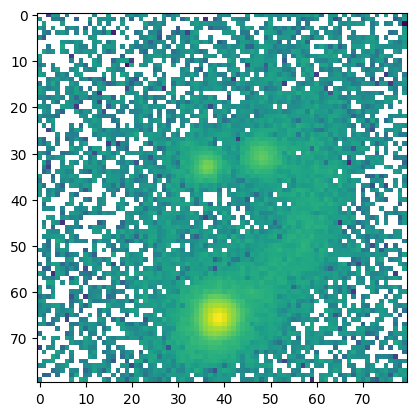

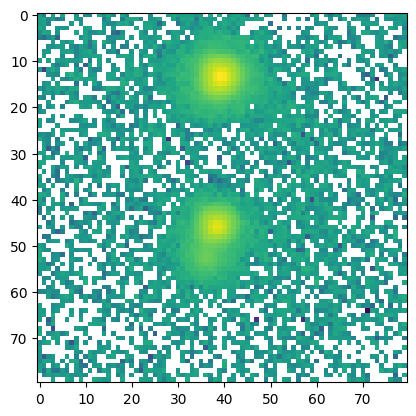

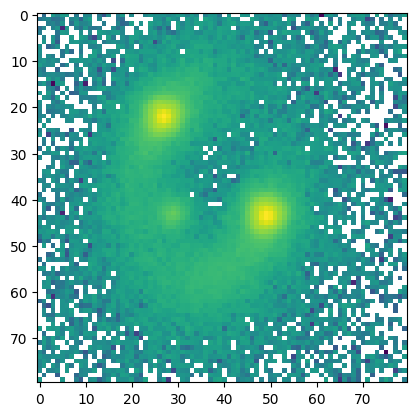

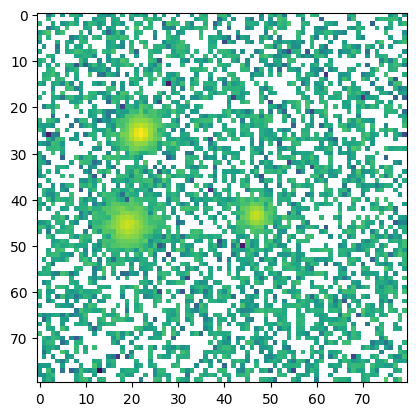

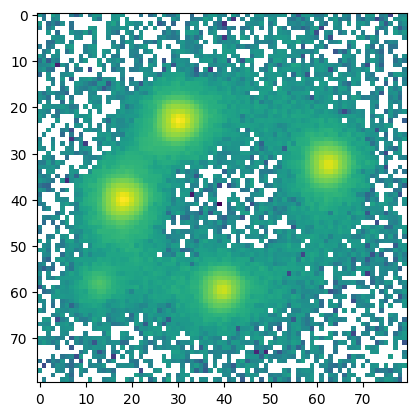

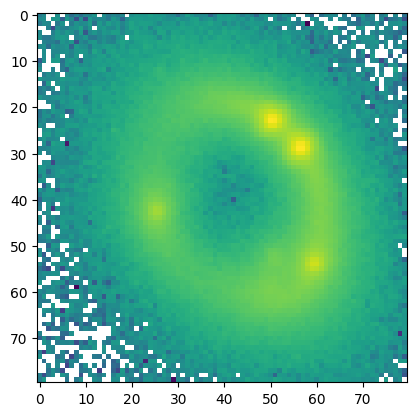

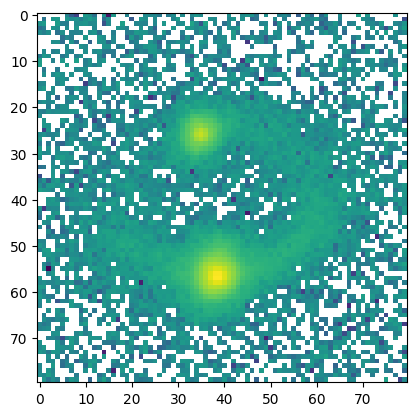

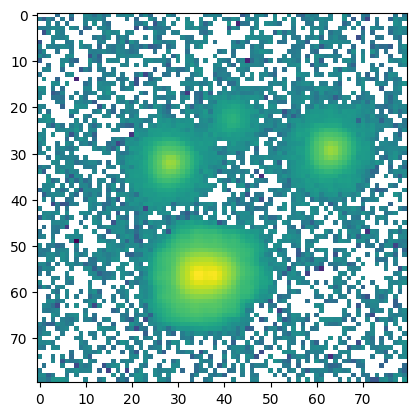

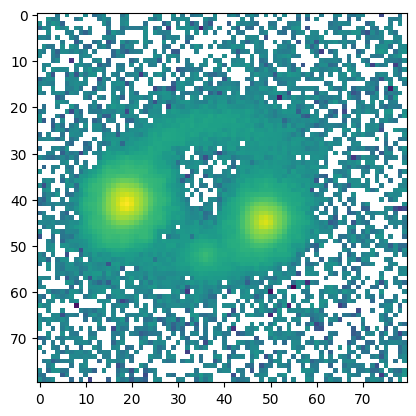

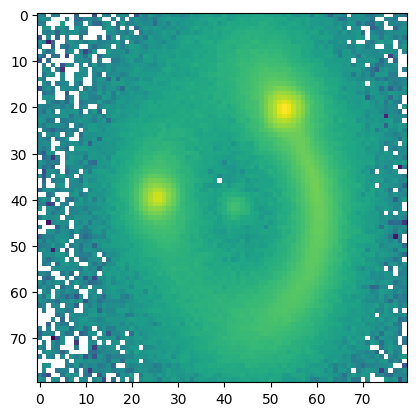

<Figure size 640x480 with 0 Axes>

In [2]:
from paltas.Configs.config_handler import ConfigHandler
from matplotlib.colors import LogNorm

for i in range(10):
    test_sample = ConfigHandler('test_config_shifted.py')
    im,metadata = test_sample.draw_image()
    plt.imshow(im,norm=LogNorm())
    plt.figure(i+2)
plt.show()

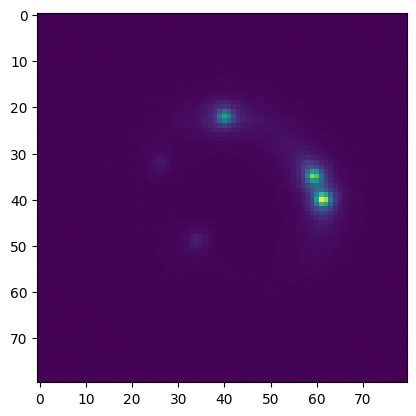

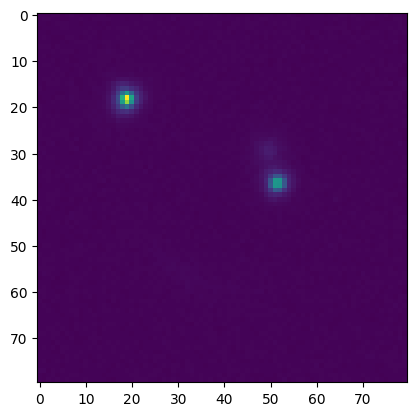

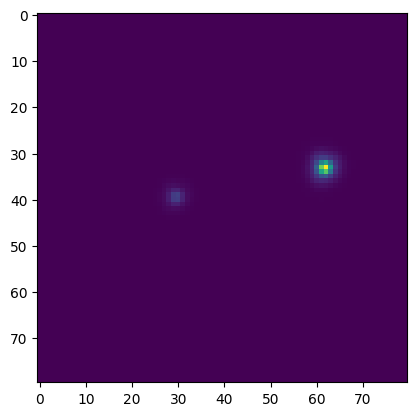

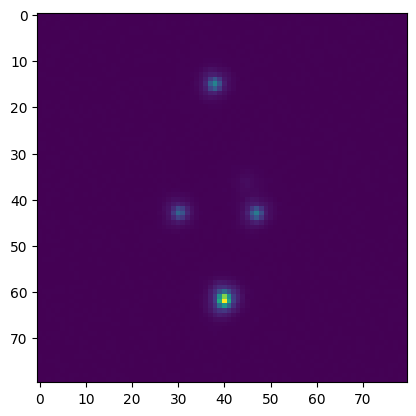

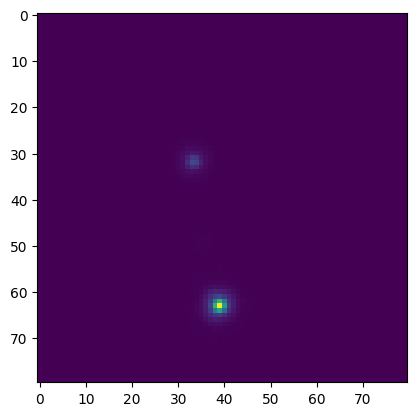

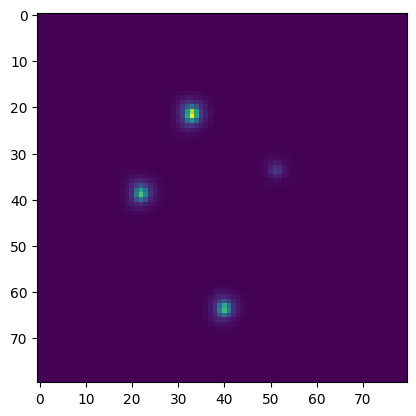

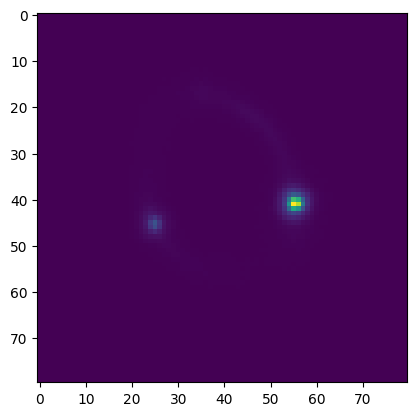

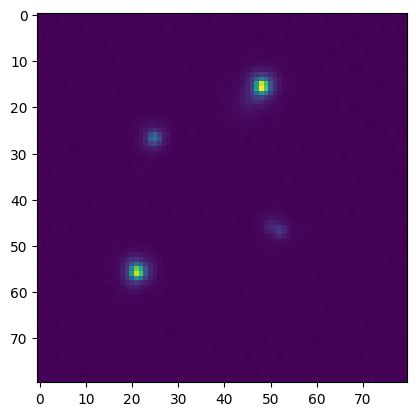

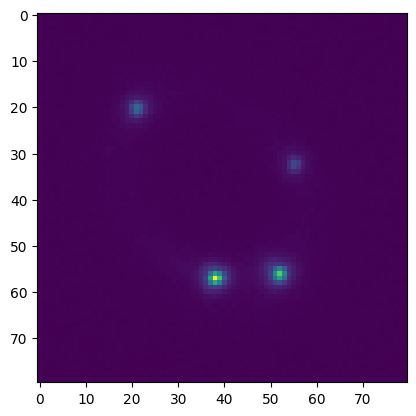

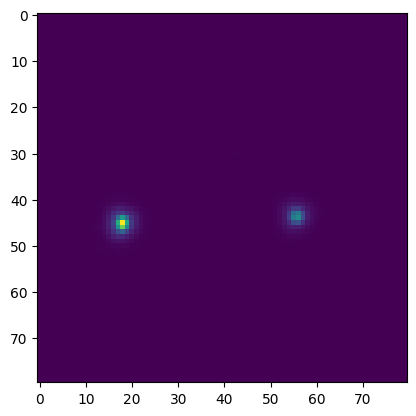

<Figure size 640x480 with 0 Axes>

In [3]:
# generate an image & store it so we can feed it into the neural network

os.system('python /Users/Logan/AppData/Local/Programs/Python/Python312/Lib/site-packages/paltas/paltas/generate.py test_config_shifted.py test_sample_image --n 10 --save_png_too --tf_record')
for i in range(10):
    plt.imshow(np.load('/Users/Logan/Documents/SJSU/HEP_Research/Mass_Modeling/psJ1606/test_sample_image/image_000000'+str(i)+'.npy'))
    plt.figure(i+2)
plt.show()

### 2) Generate network predictions

In [4]:
# compute predictions for test sets 
path_to_weights = 'xresnet34_068--14.58.h5'
path_to_norms = 'norms.csv'

learning_params = ['main_deflector_parameters_theta_E','main_deflector_parameters_gamma1',
                   'main_deflector_parameters_gamma2','main_deflector_parameters_gamma',
                   'main_deflector_parameters_e1','main_deflector_parameters_e2',
                   'main_deflector_parameters_center_x','main_deflector_parameters_center_y',
                   'source_parameters_center_x','source_parameters_center_y']
learning_params_names = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
								r'$e_2$',r'$x_{lens}$',r'$y_{lens}$',r'$x_{src}$',r'$y_{src}$']

model_predictions = network_predictions.NetworkPredictions(path_to_weights,path_to_norms,
    learning_params,loss_type='diag',model_type='xresnet34',norm_type='lognorm')

In [5]:
y_test, y_pred, std_pred, prec_pred = model_predictions.gen_network_predictions(test_folder='test_sample_image')

# NOTE: there is a mismatch in the coordinate system, so I have to transform x,y predictions accordingly (this doesn't change the results)
# x-coords
y_pred[:,6] = - (y_pred[:,6]-0.02)
y_pred[:,8] = - (y_pred[:,8]-0.02)
# y-coords
y_pred[:,7] = - (y_pred[:,7]+0.02)
y_pred[:,9] = - (y_pred[:,9]+0.02)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step


In [6]:
print('ground truth: ', y_test)
print('prediction: ', y_pred)

ground truth:  [[ 0.6530375   0.09697873  0.07261989  2.133629    0.17834775 -0.35548556
   0.03529944  0.15475024  0.14455897 -0.07992734]
 [ 0.7406648  -0.01551295  0.16161248  2.0470161   0.24570014 -0.13689531
   0.0698461  -0.01685009 -0.21925746 -0.04967779]
 [ 0.62219906  0.09225903 -0.04520913  2.007787    0.28627643  0.06753037
   0.01663533  0.03298901  0.24758634 -0.02007717]
 [ 0.5030423  -0.37861958  0.01573329  1.9585718   0.14011574 -0.01312385
  -0.10435365  0.06858645 -0.12309203 -0.0048992 ]
 [ 0.6327124  -0.11636676 -0.02909284  2.0691478   0.00329777  0.3754065
  -0.03537764 -0.10040396  0.08818636  0.18060292]
 [ 0.78358936  0.02883166 -0.06732824  1.9327439   0.41306025 -0.213375
  -0.05333883 -0.01386096 -0.00604271  0.07444983]
 [ 0.6617481  -0.14847153  0.15819485  2.094463   -0.25511613  0.2525605
  -0.11276393 -0.00630698 -0.00459143 -0.0590527 ]
 [ 0.77457327 -0.08349188 -0.11641763  2.114658    0.02356414  0.29700536
  -0.01191716 -0.03836974 -0.08536183 -0

#### 3) Interpret output from the network

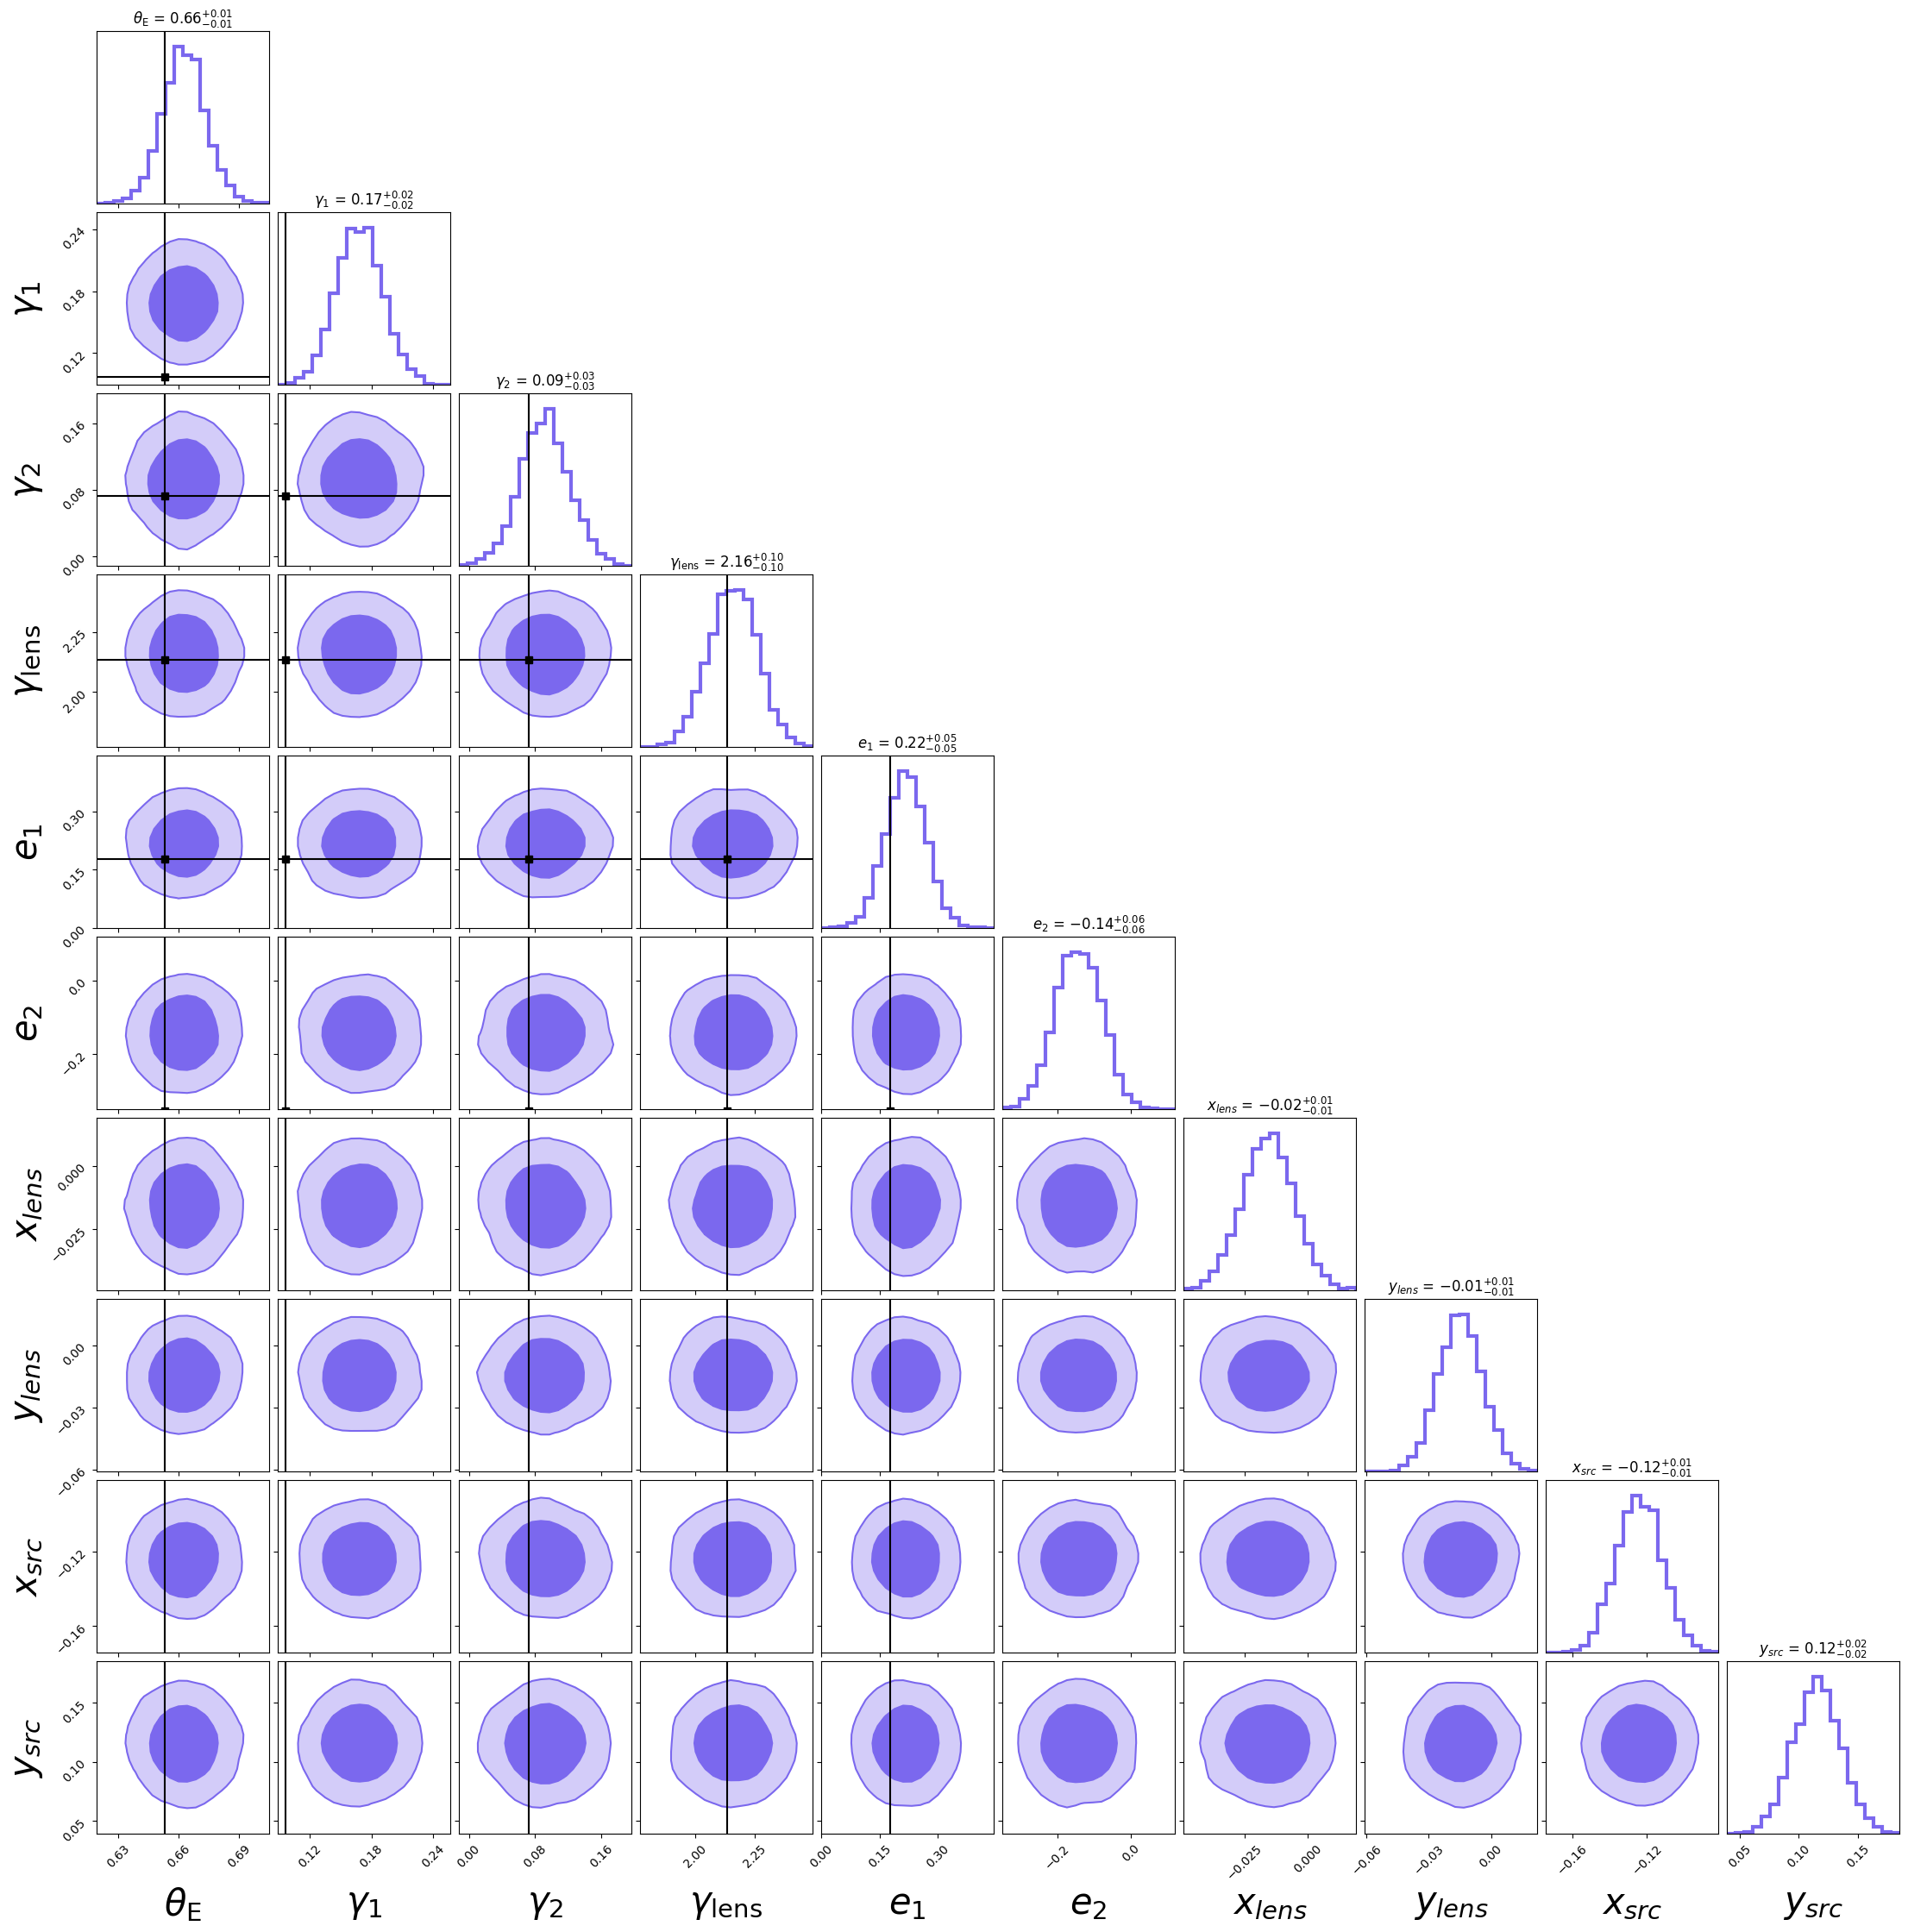

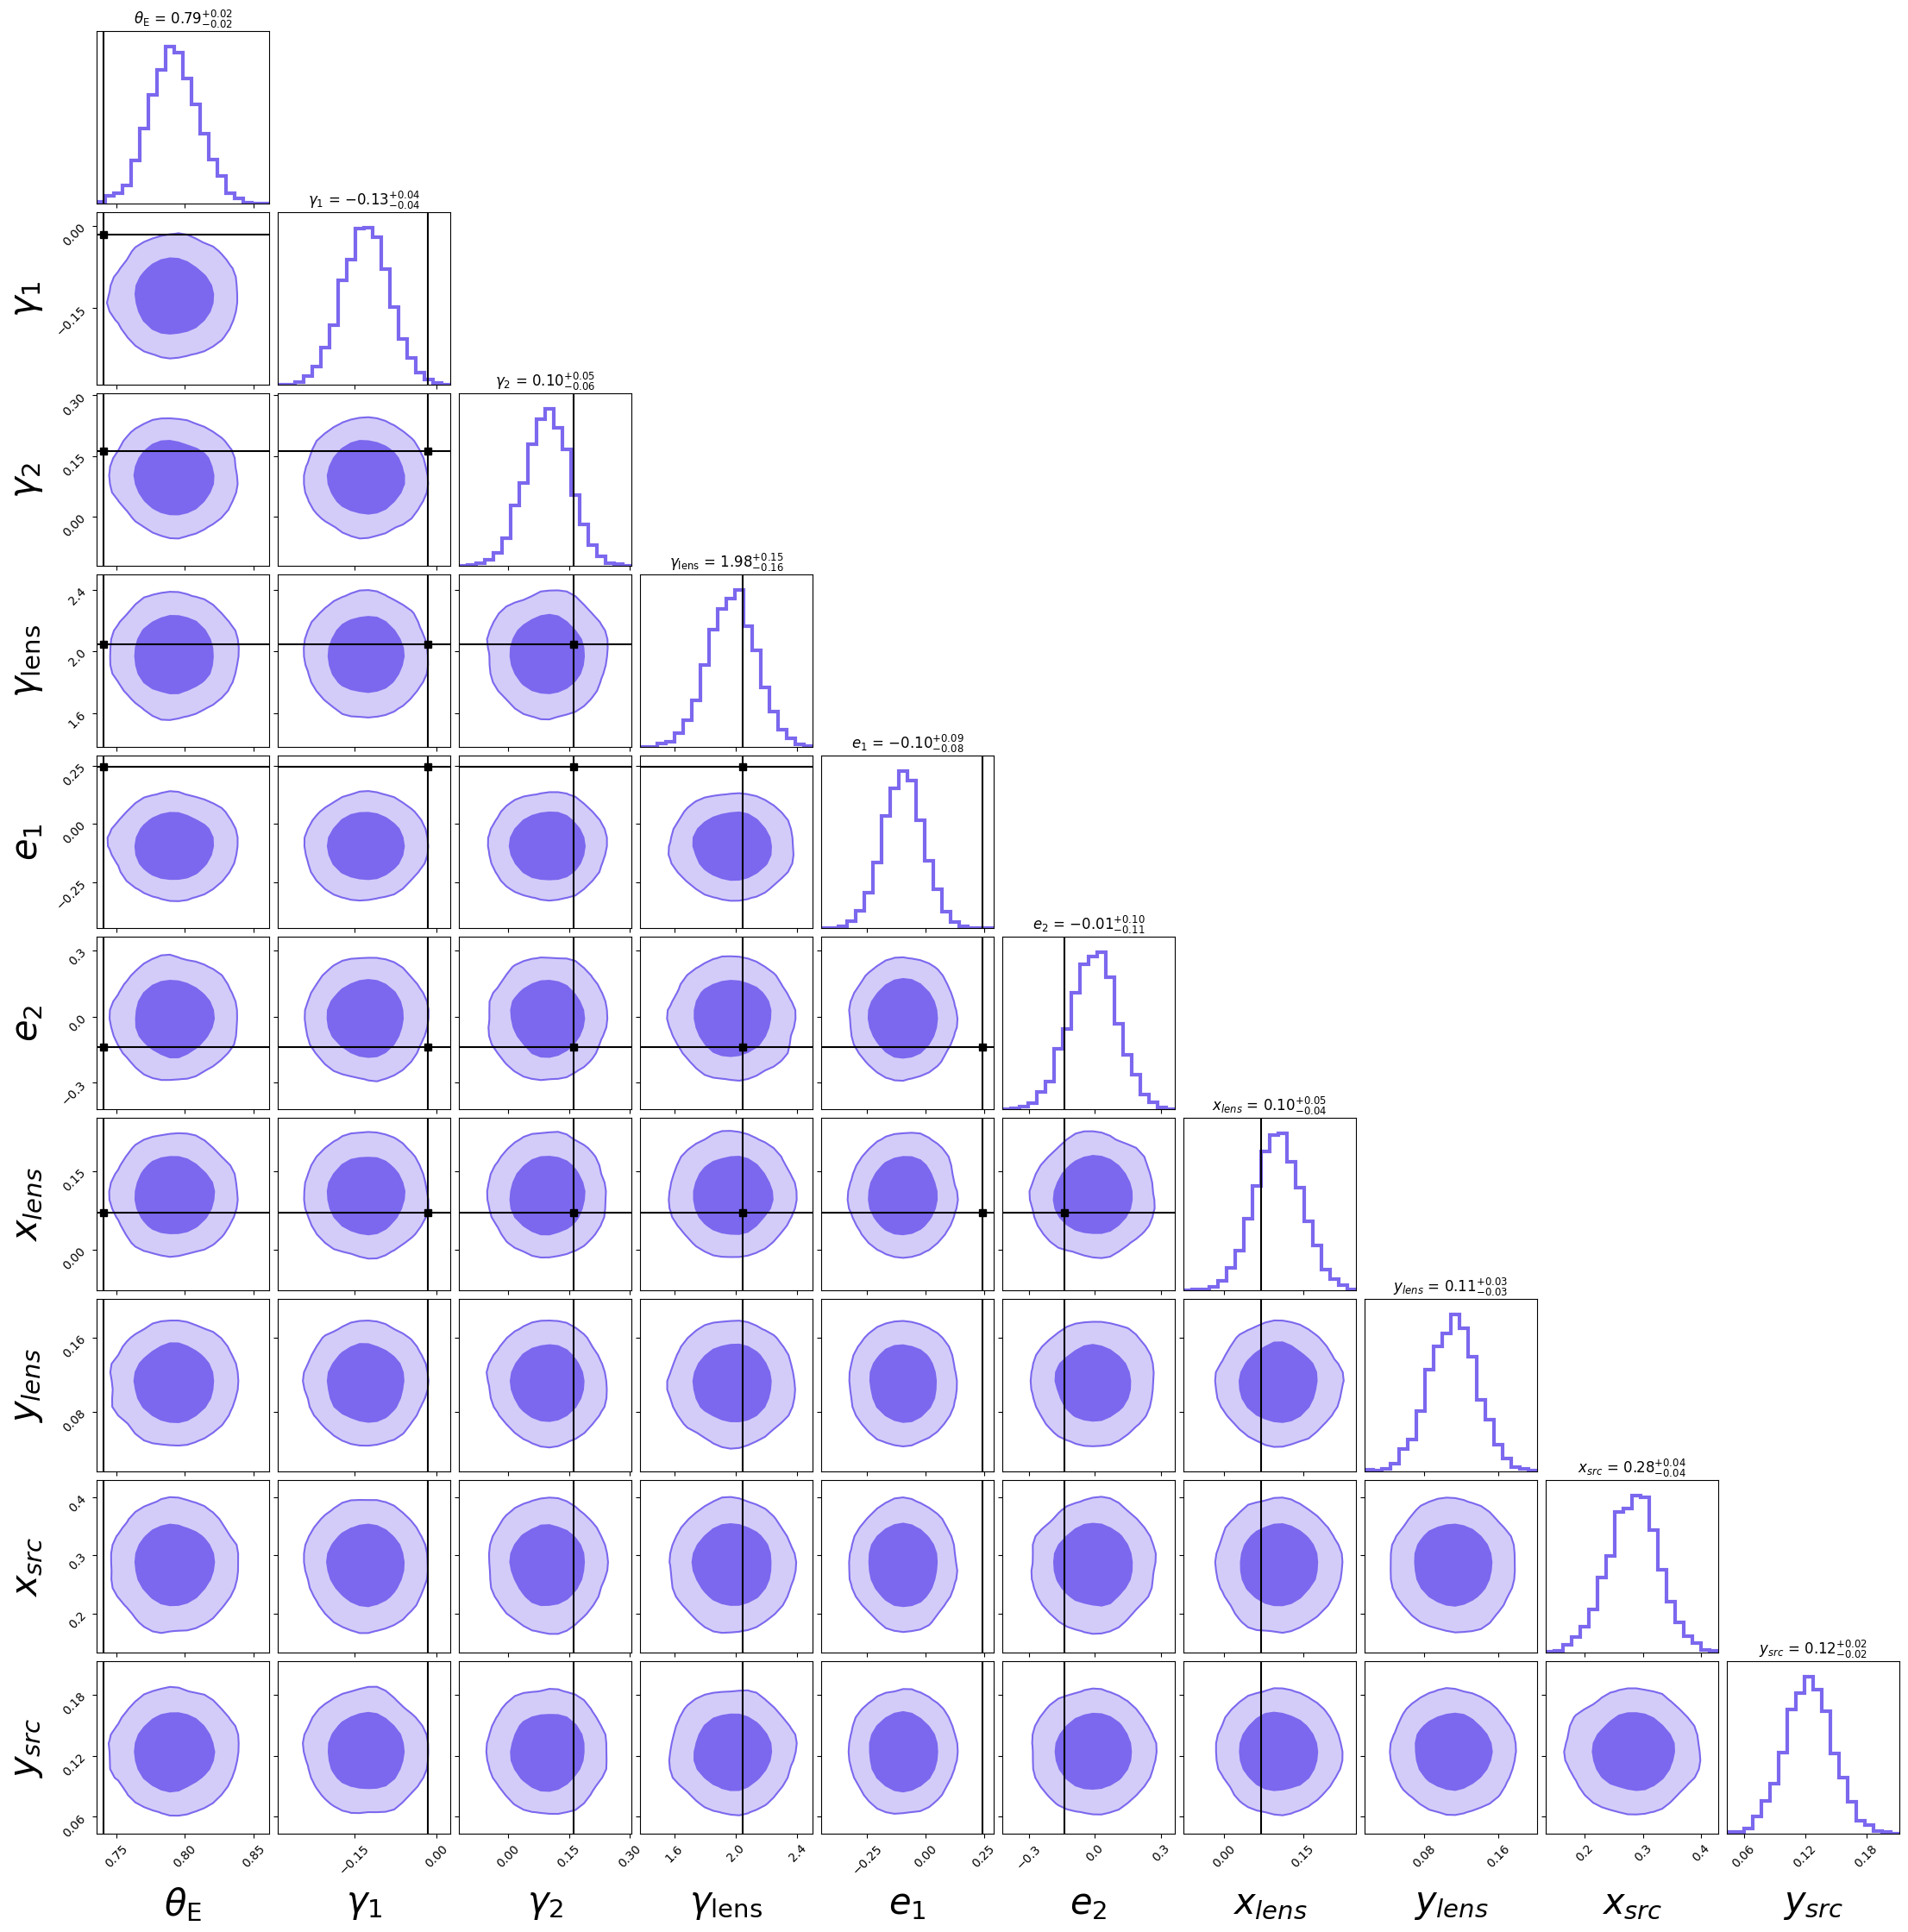

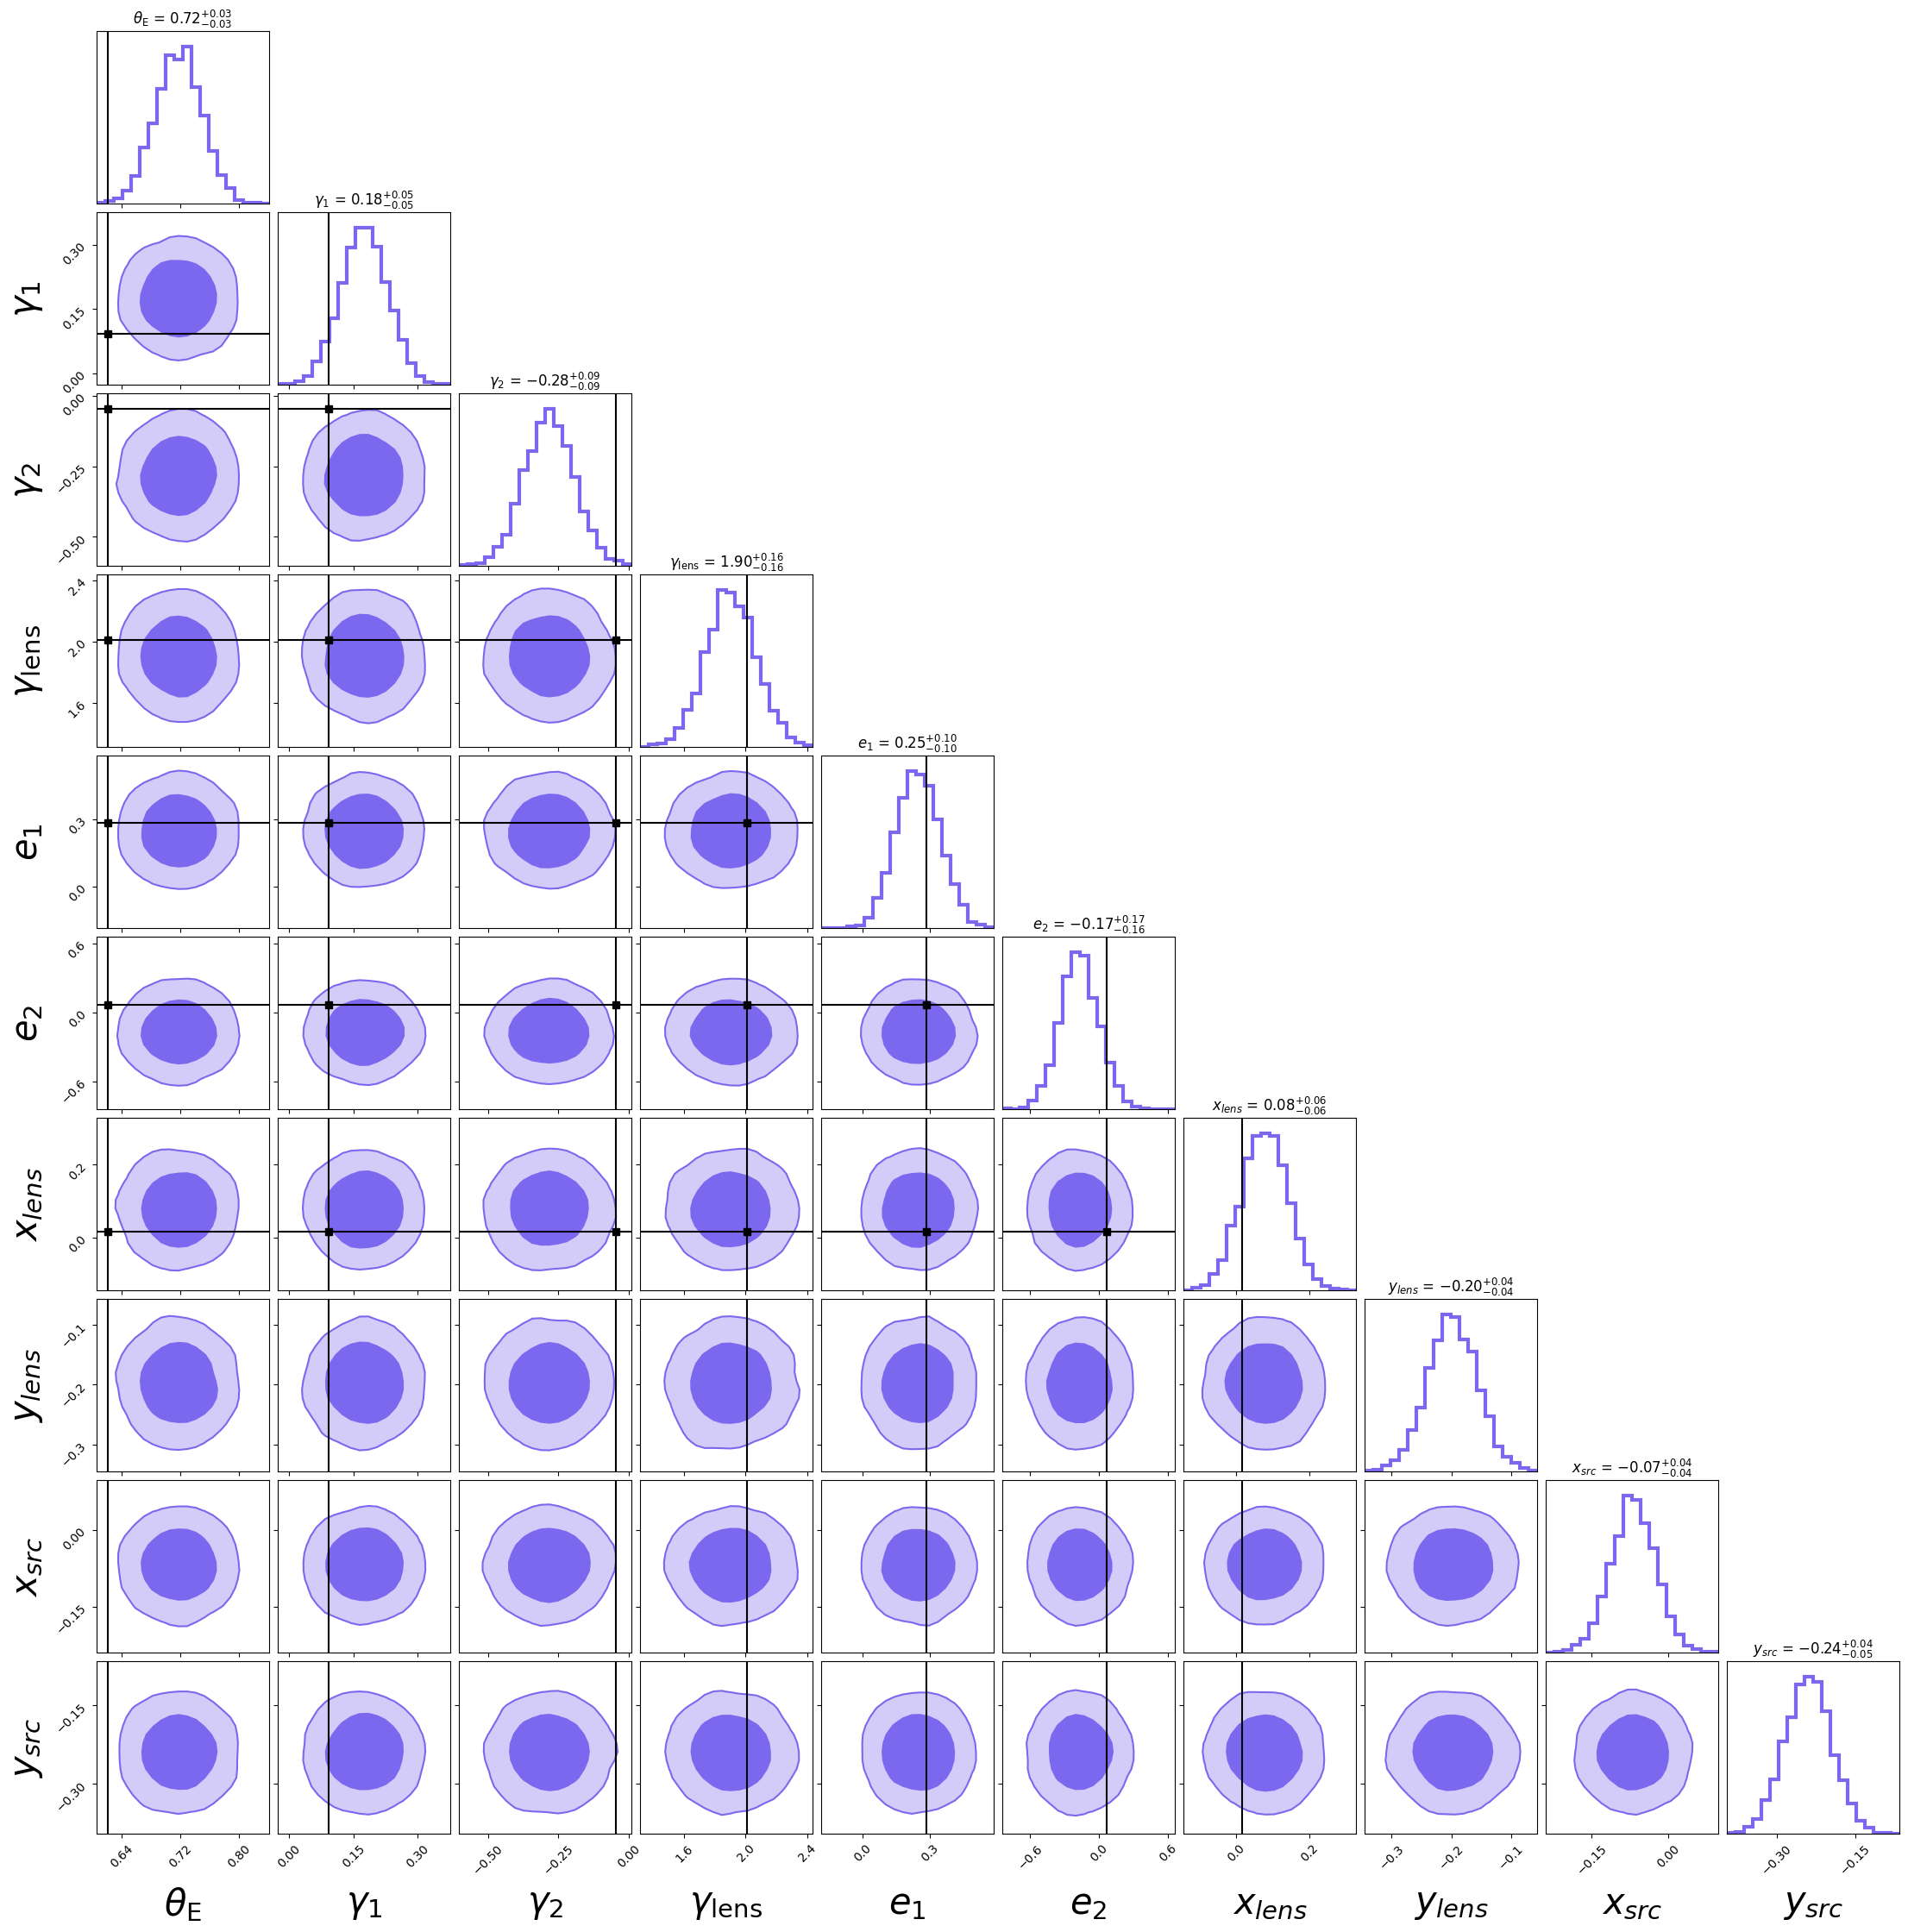

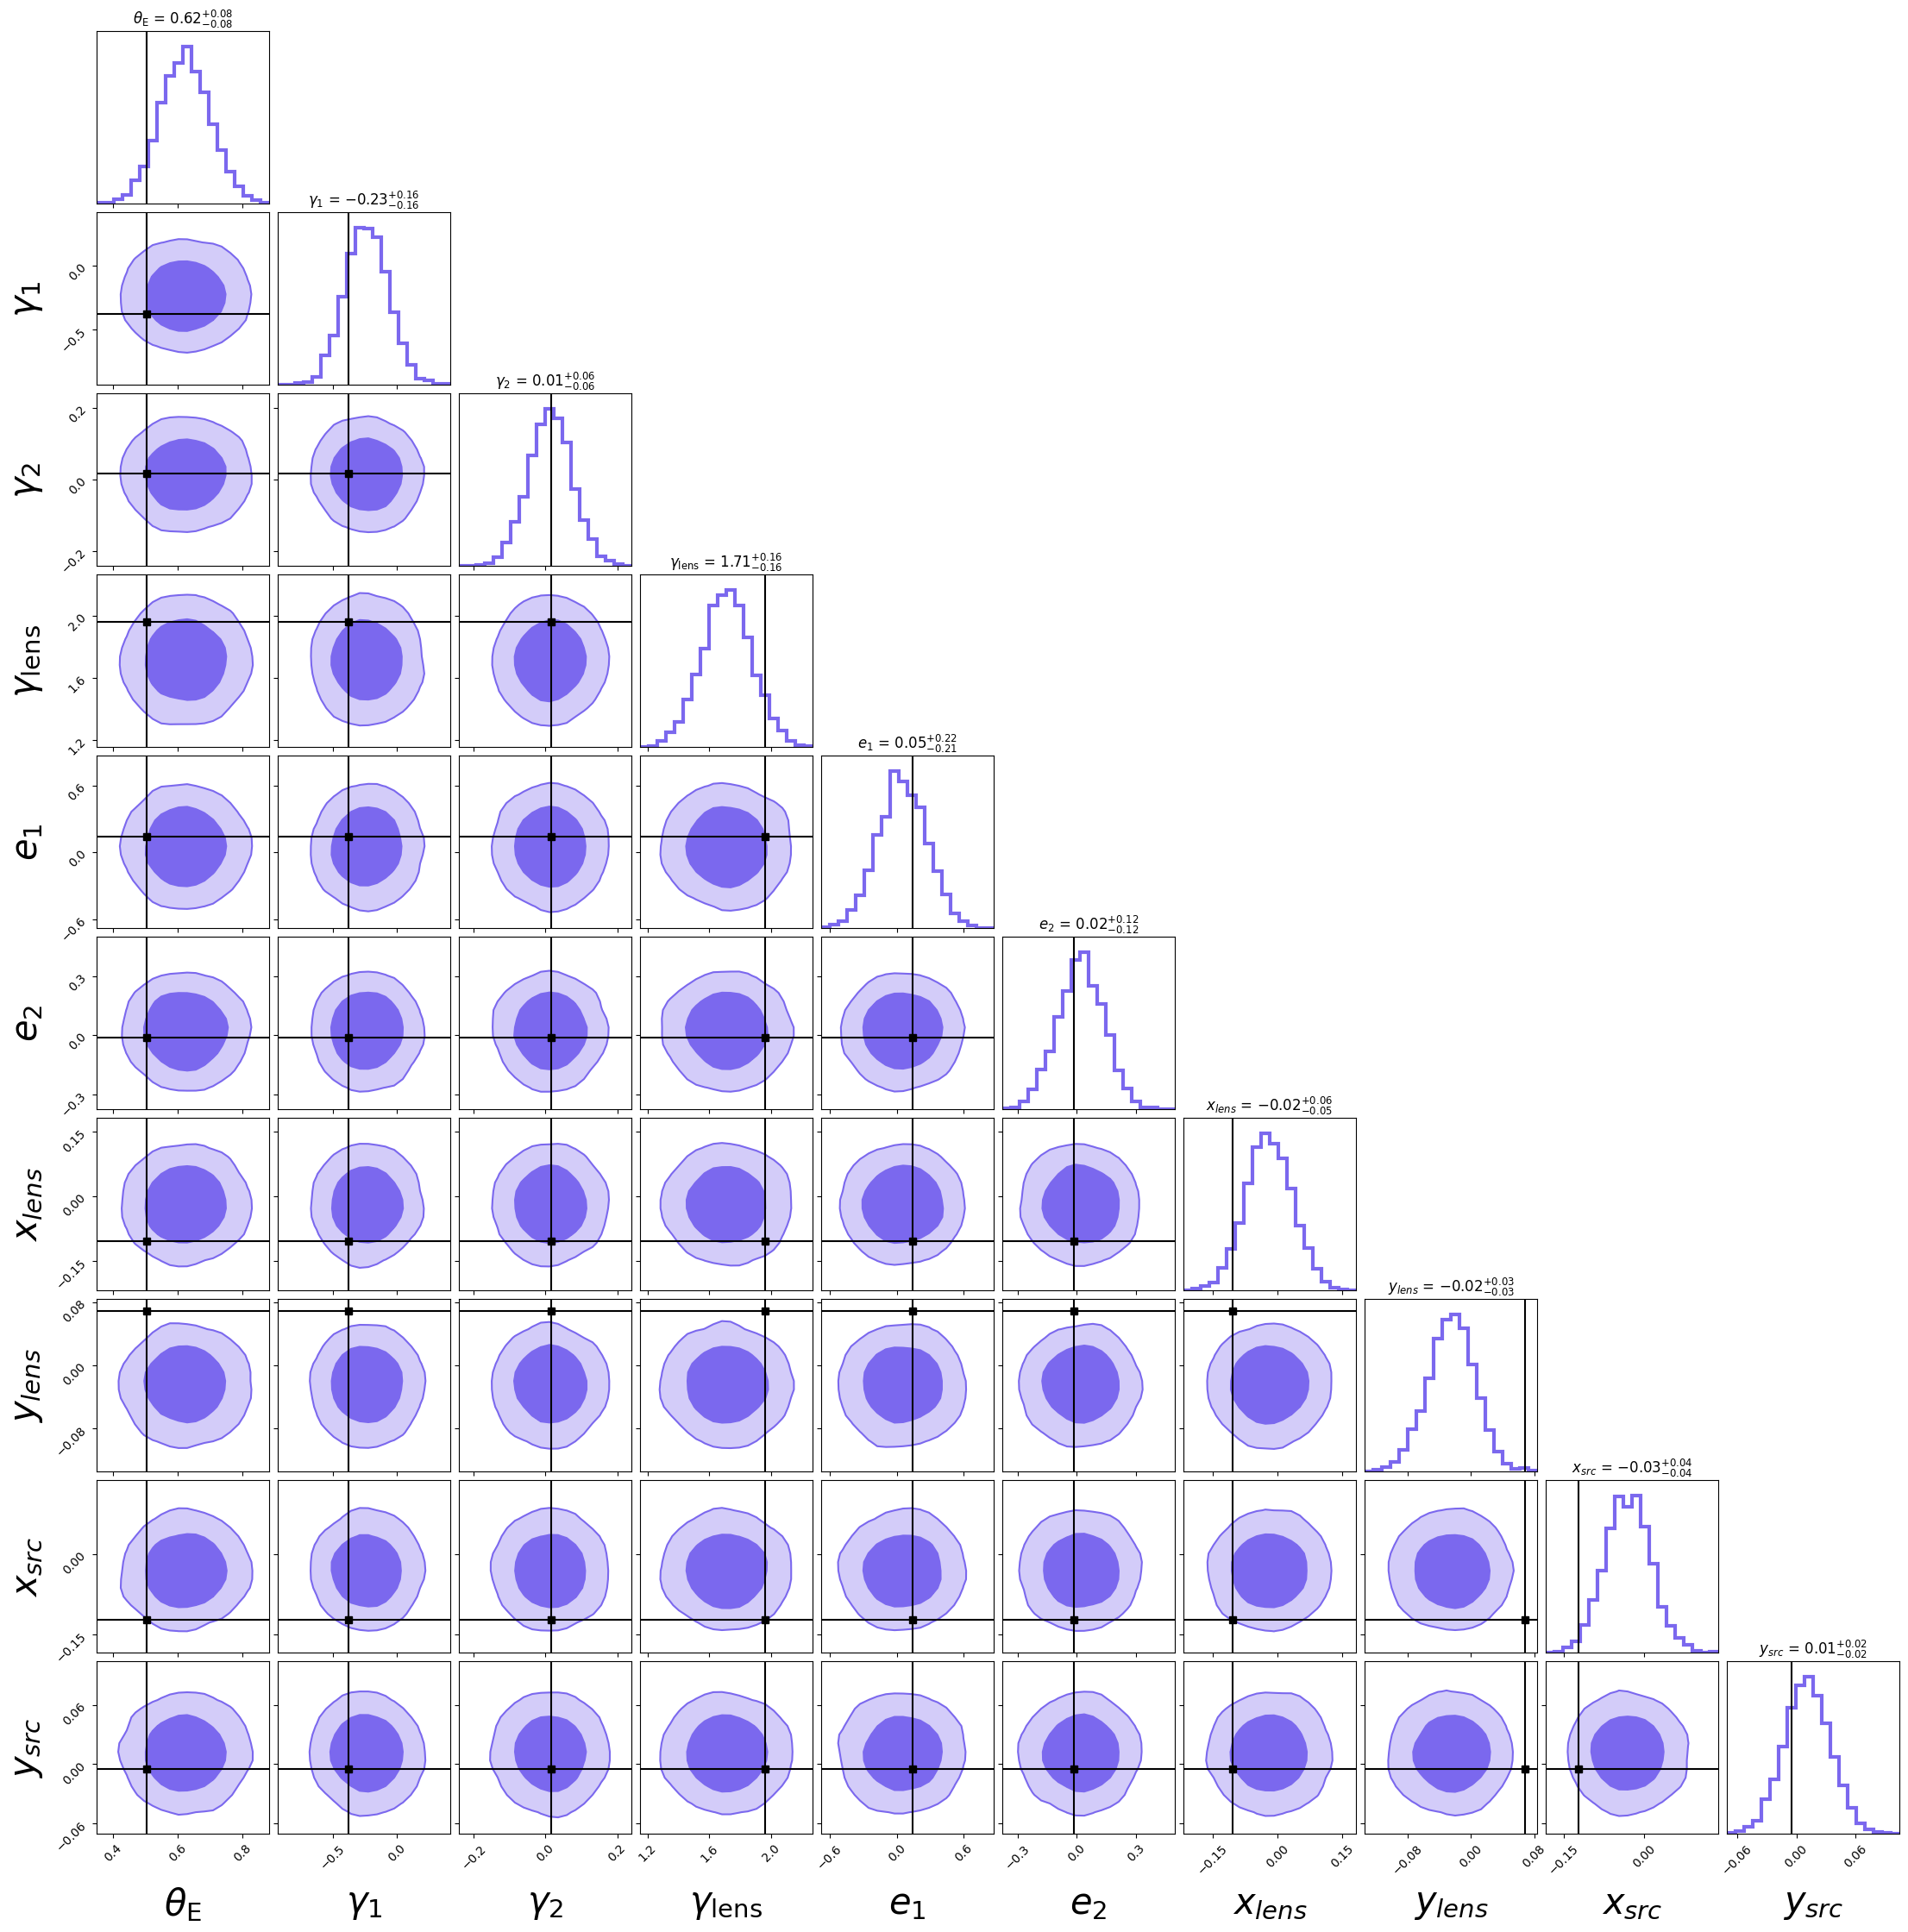

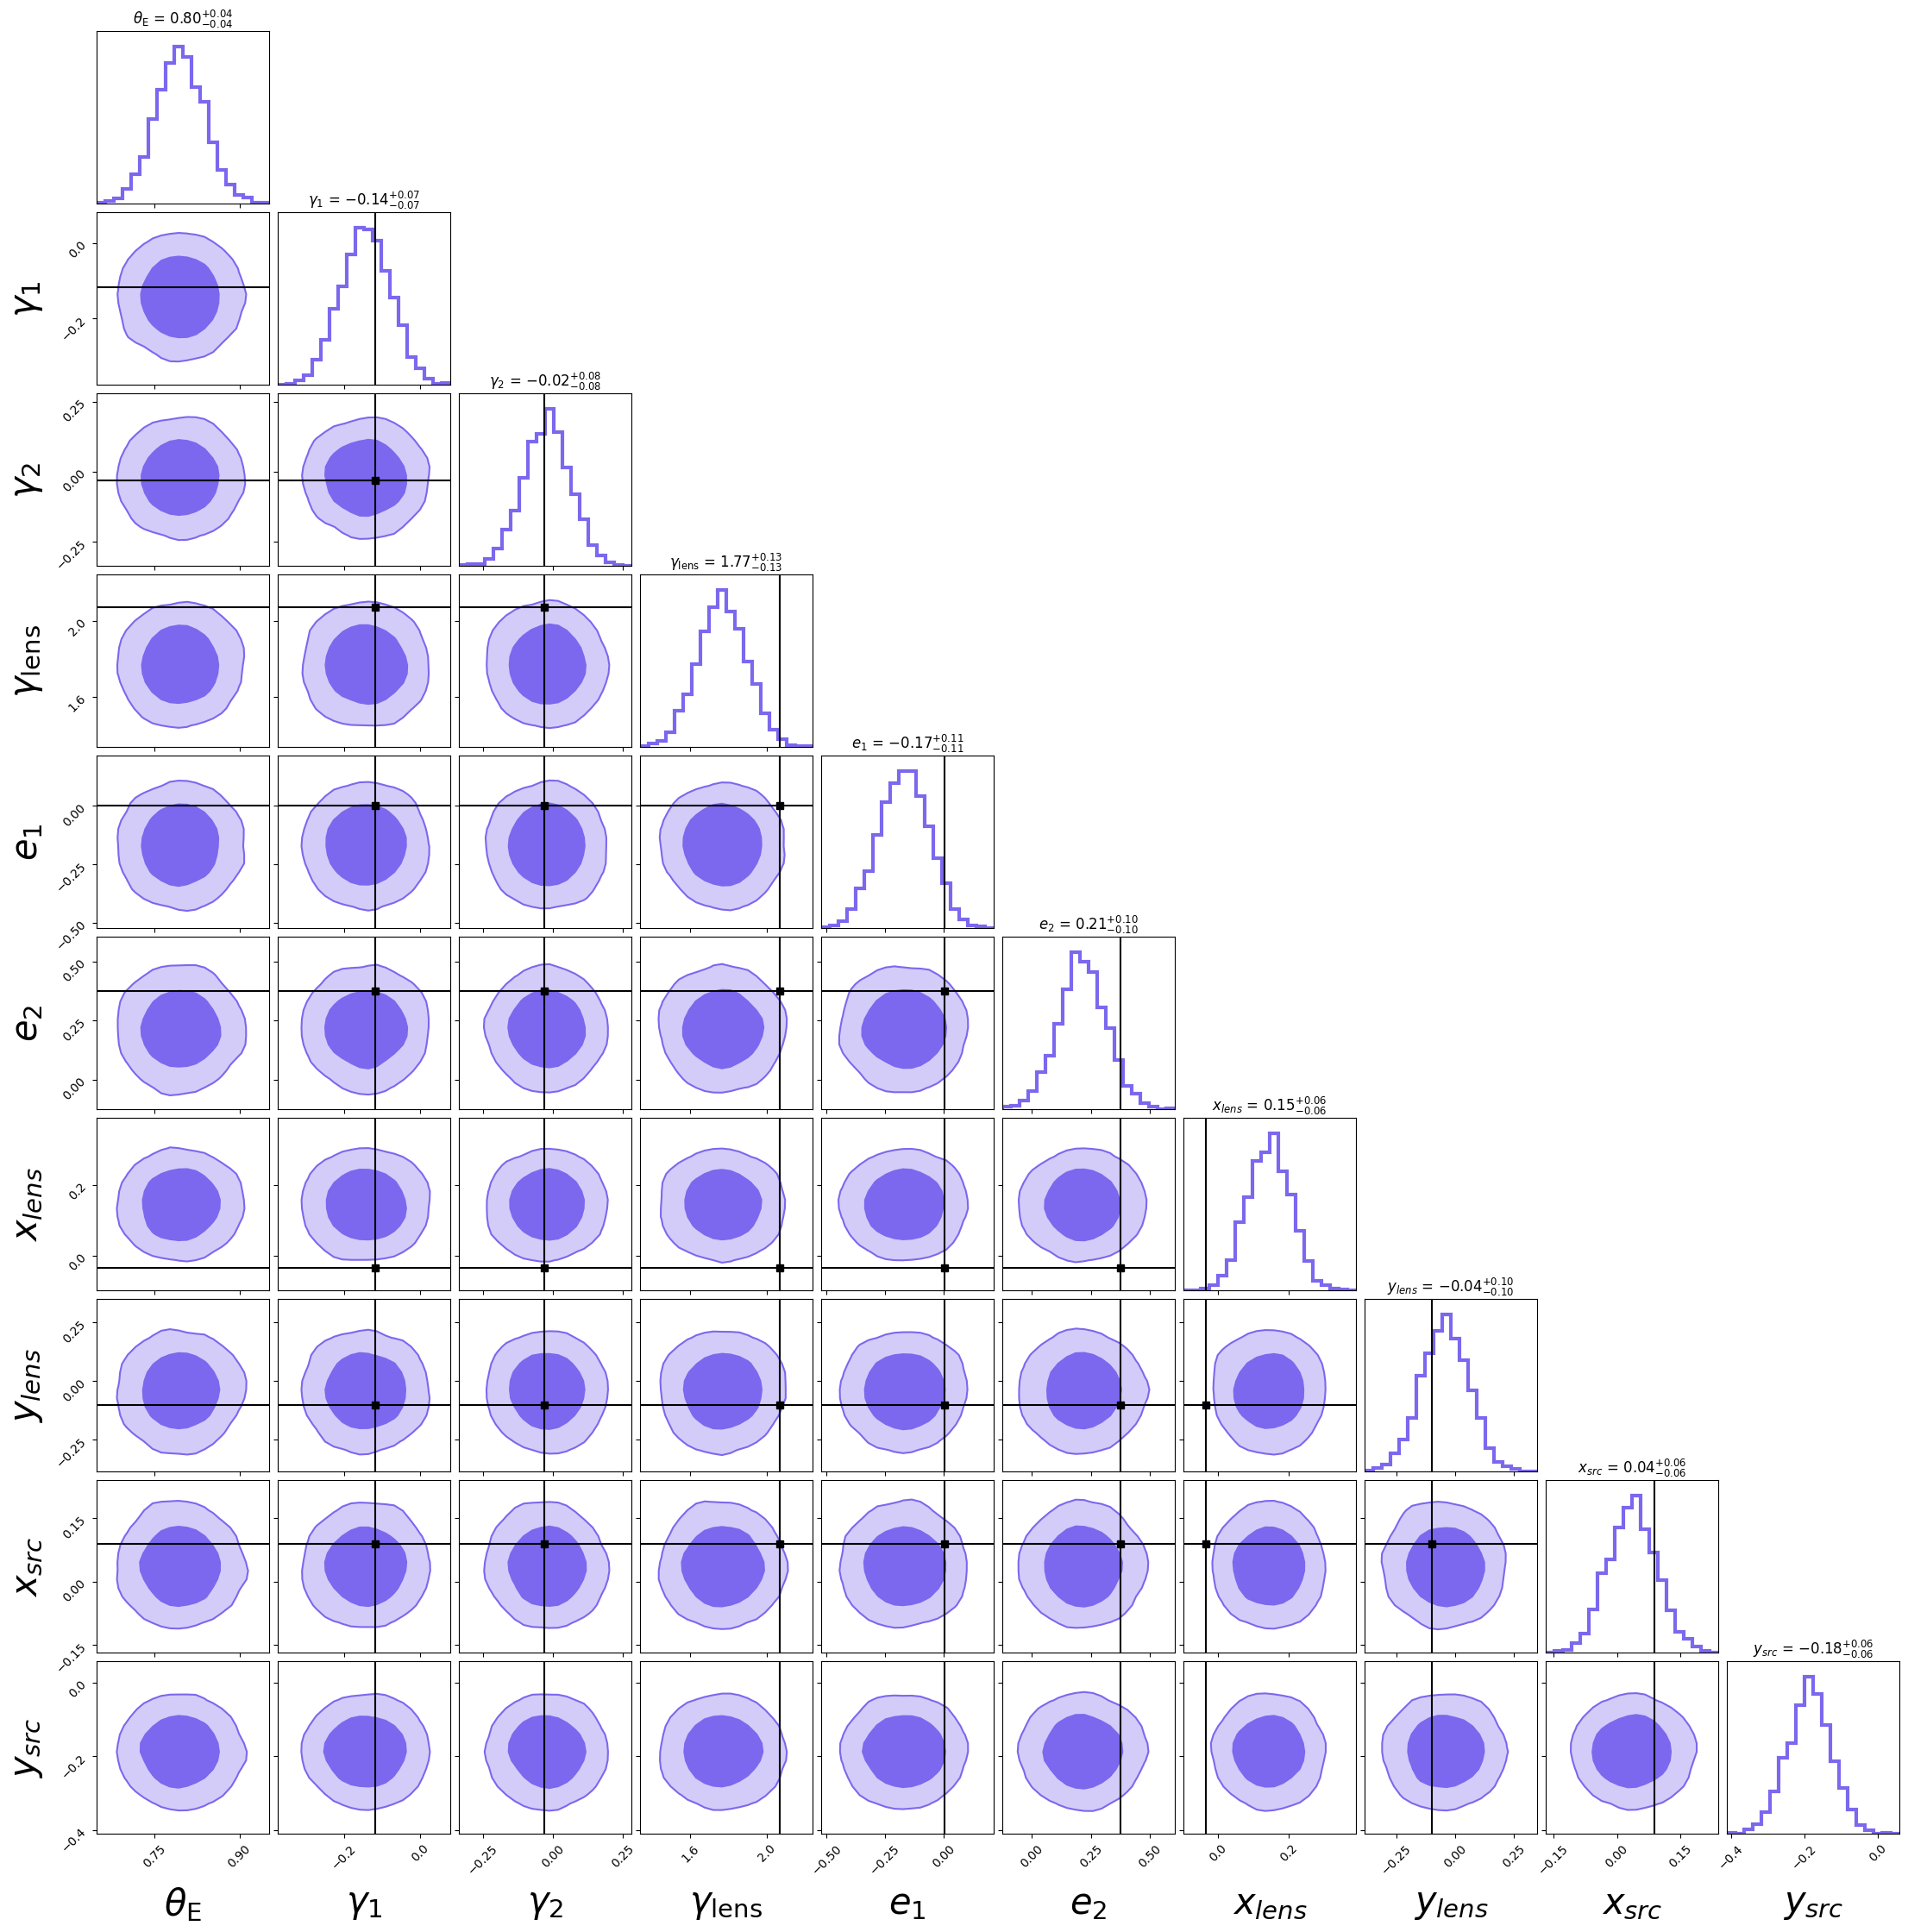

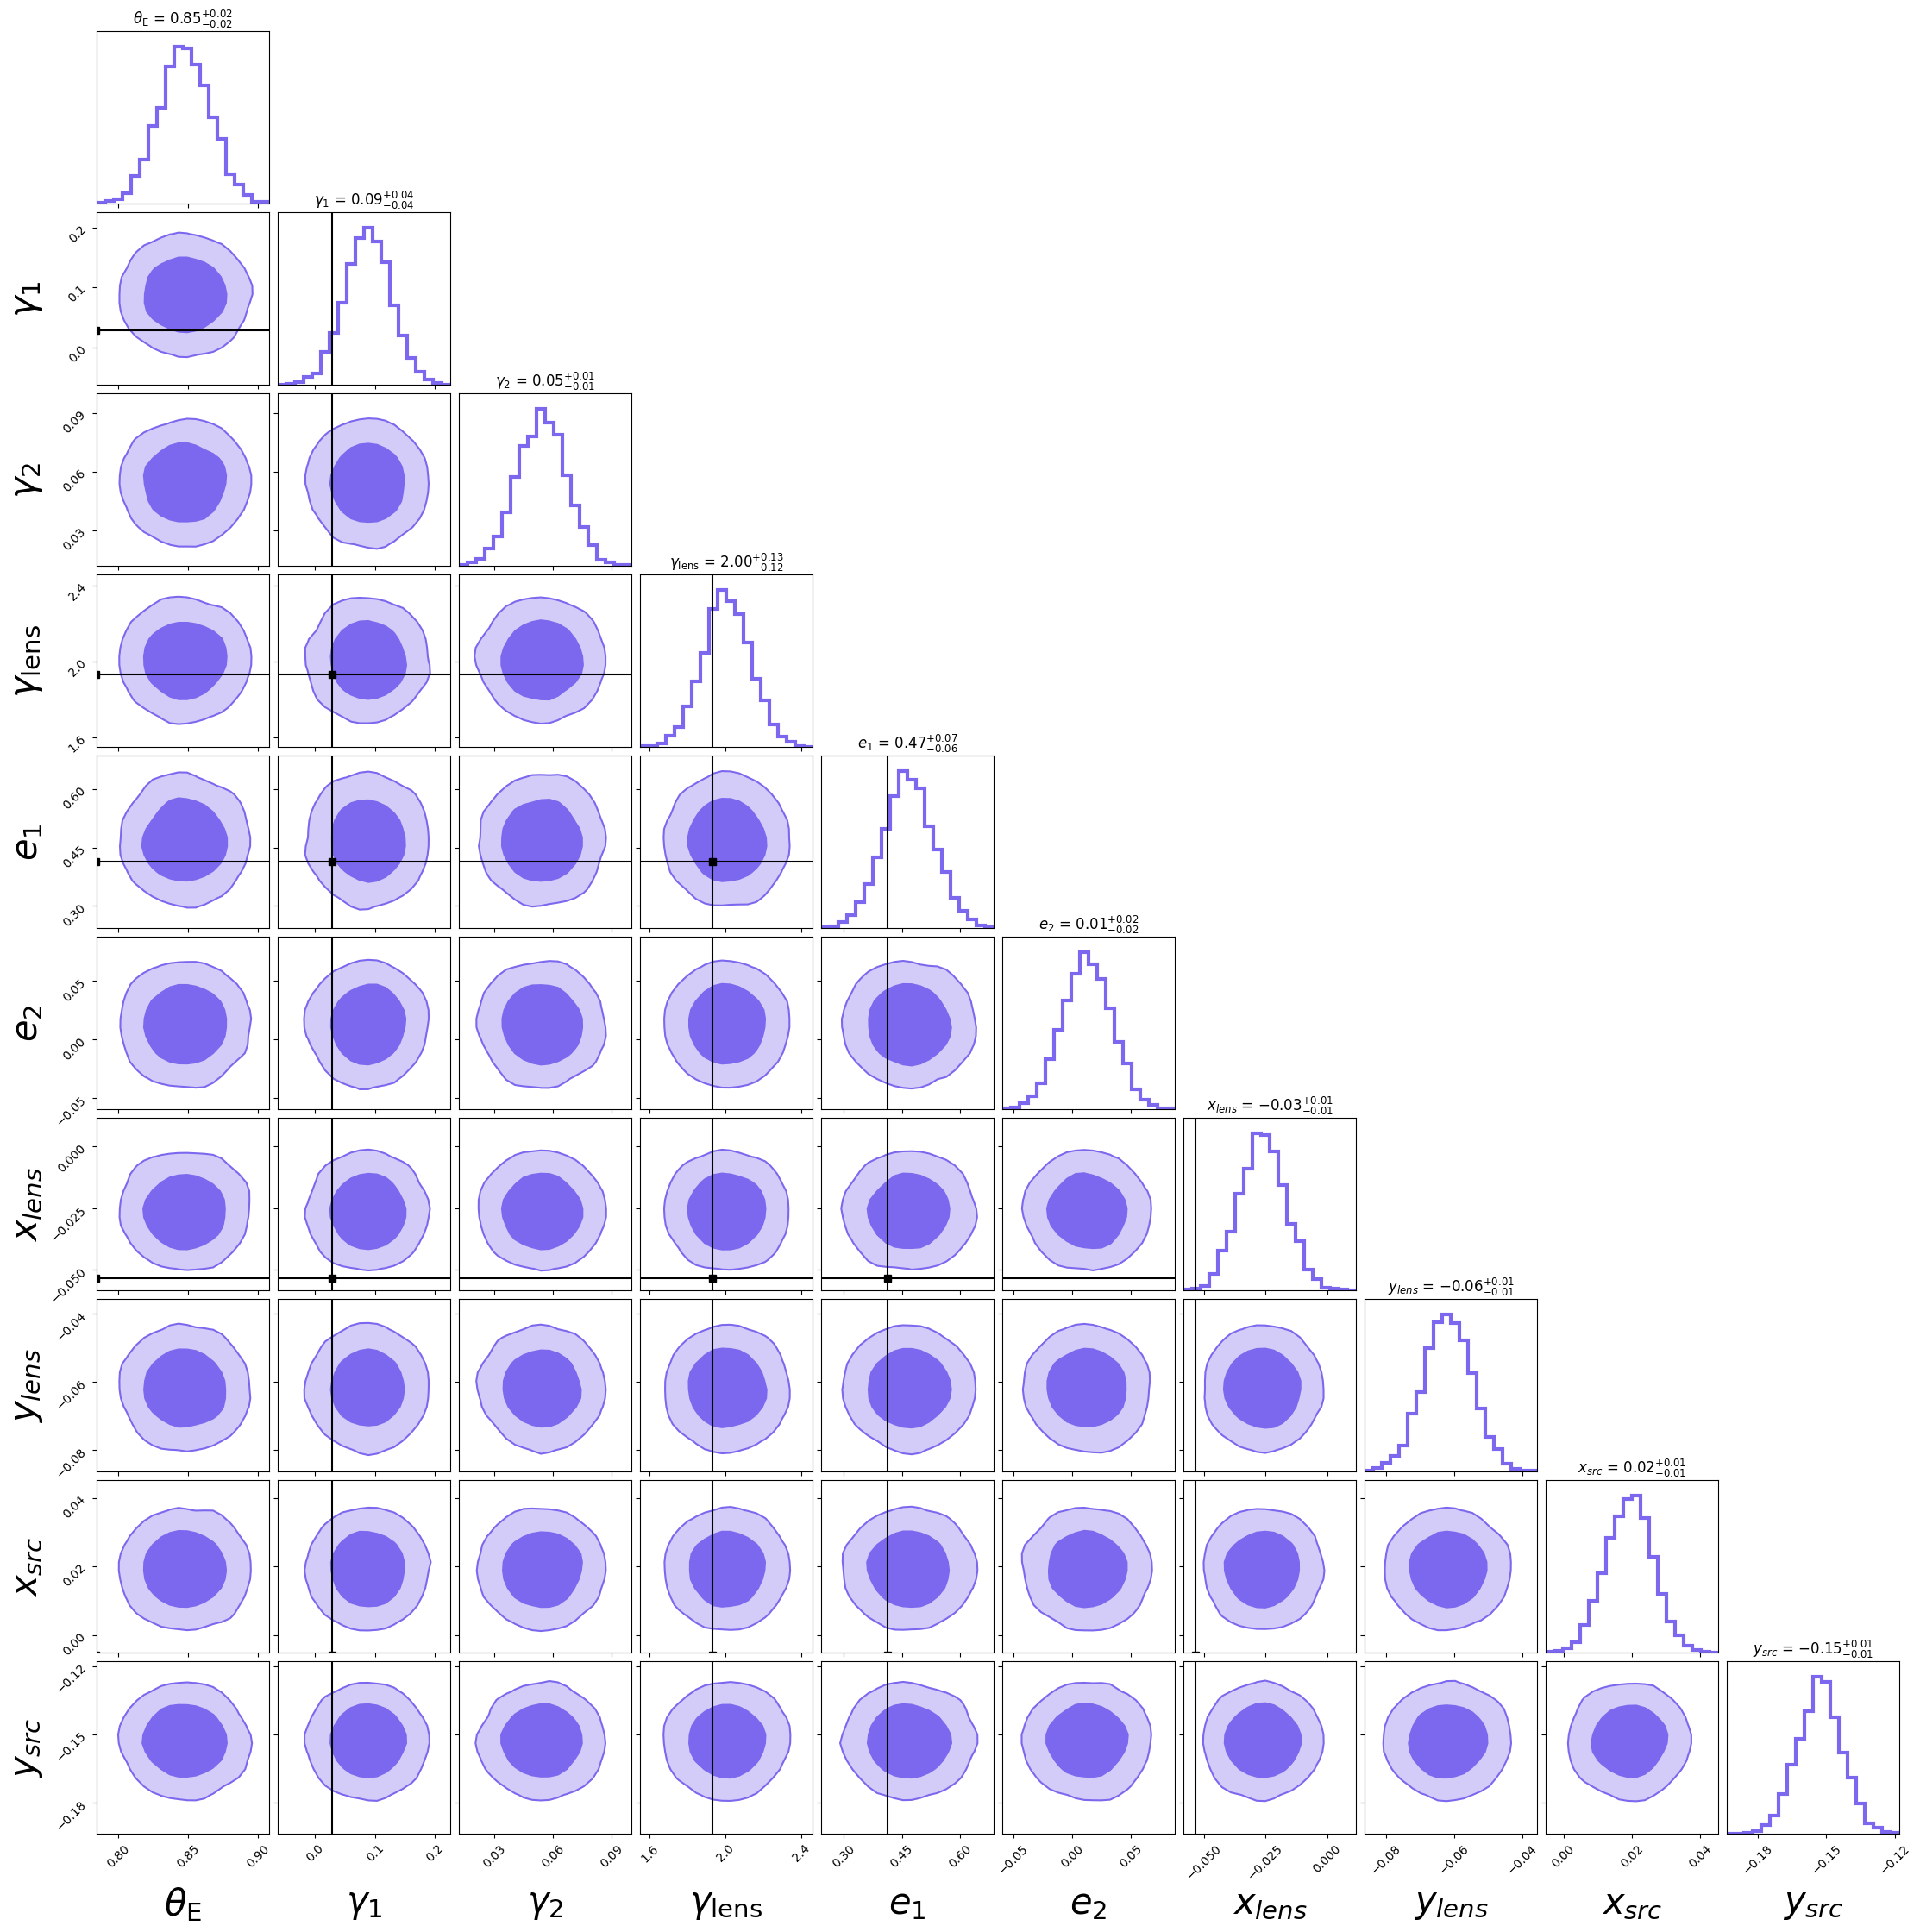

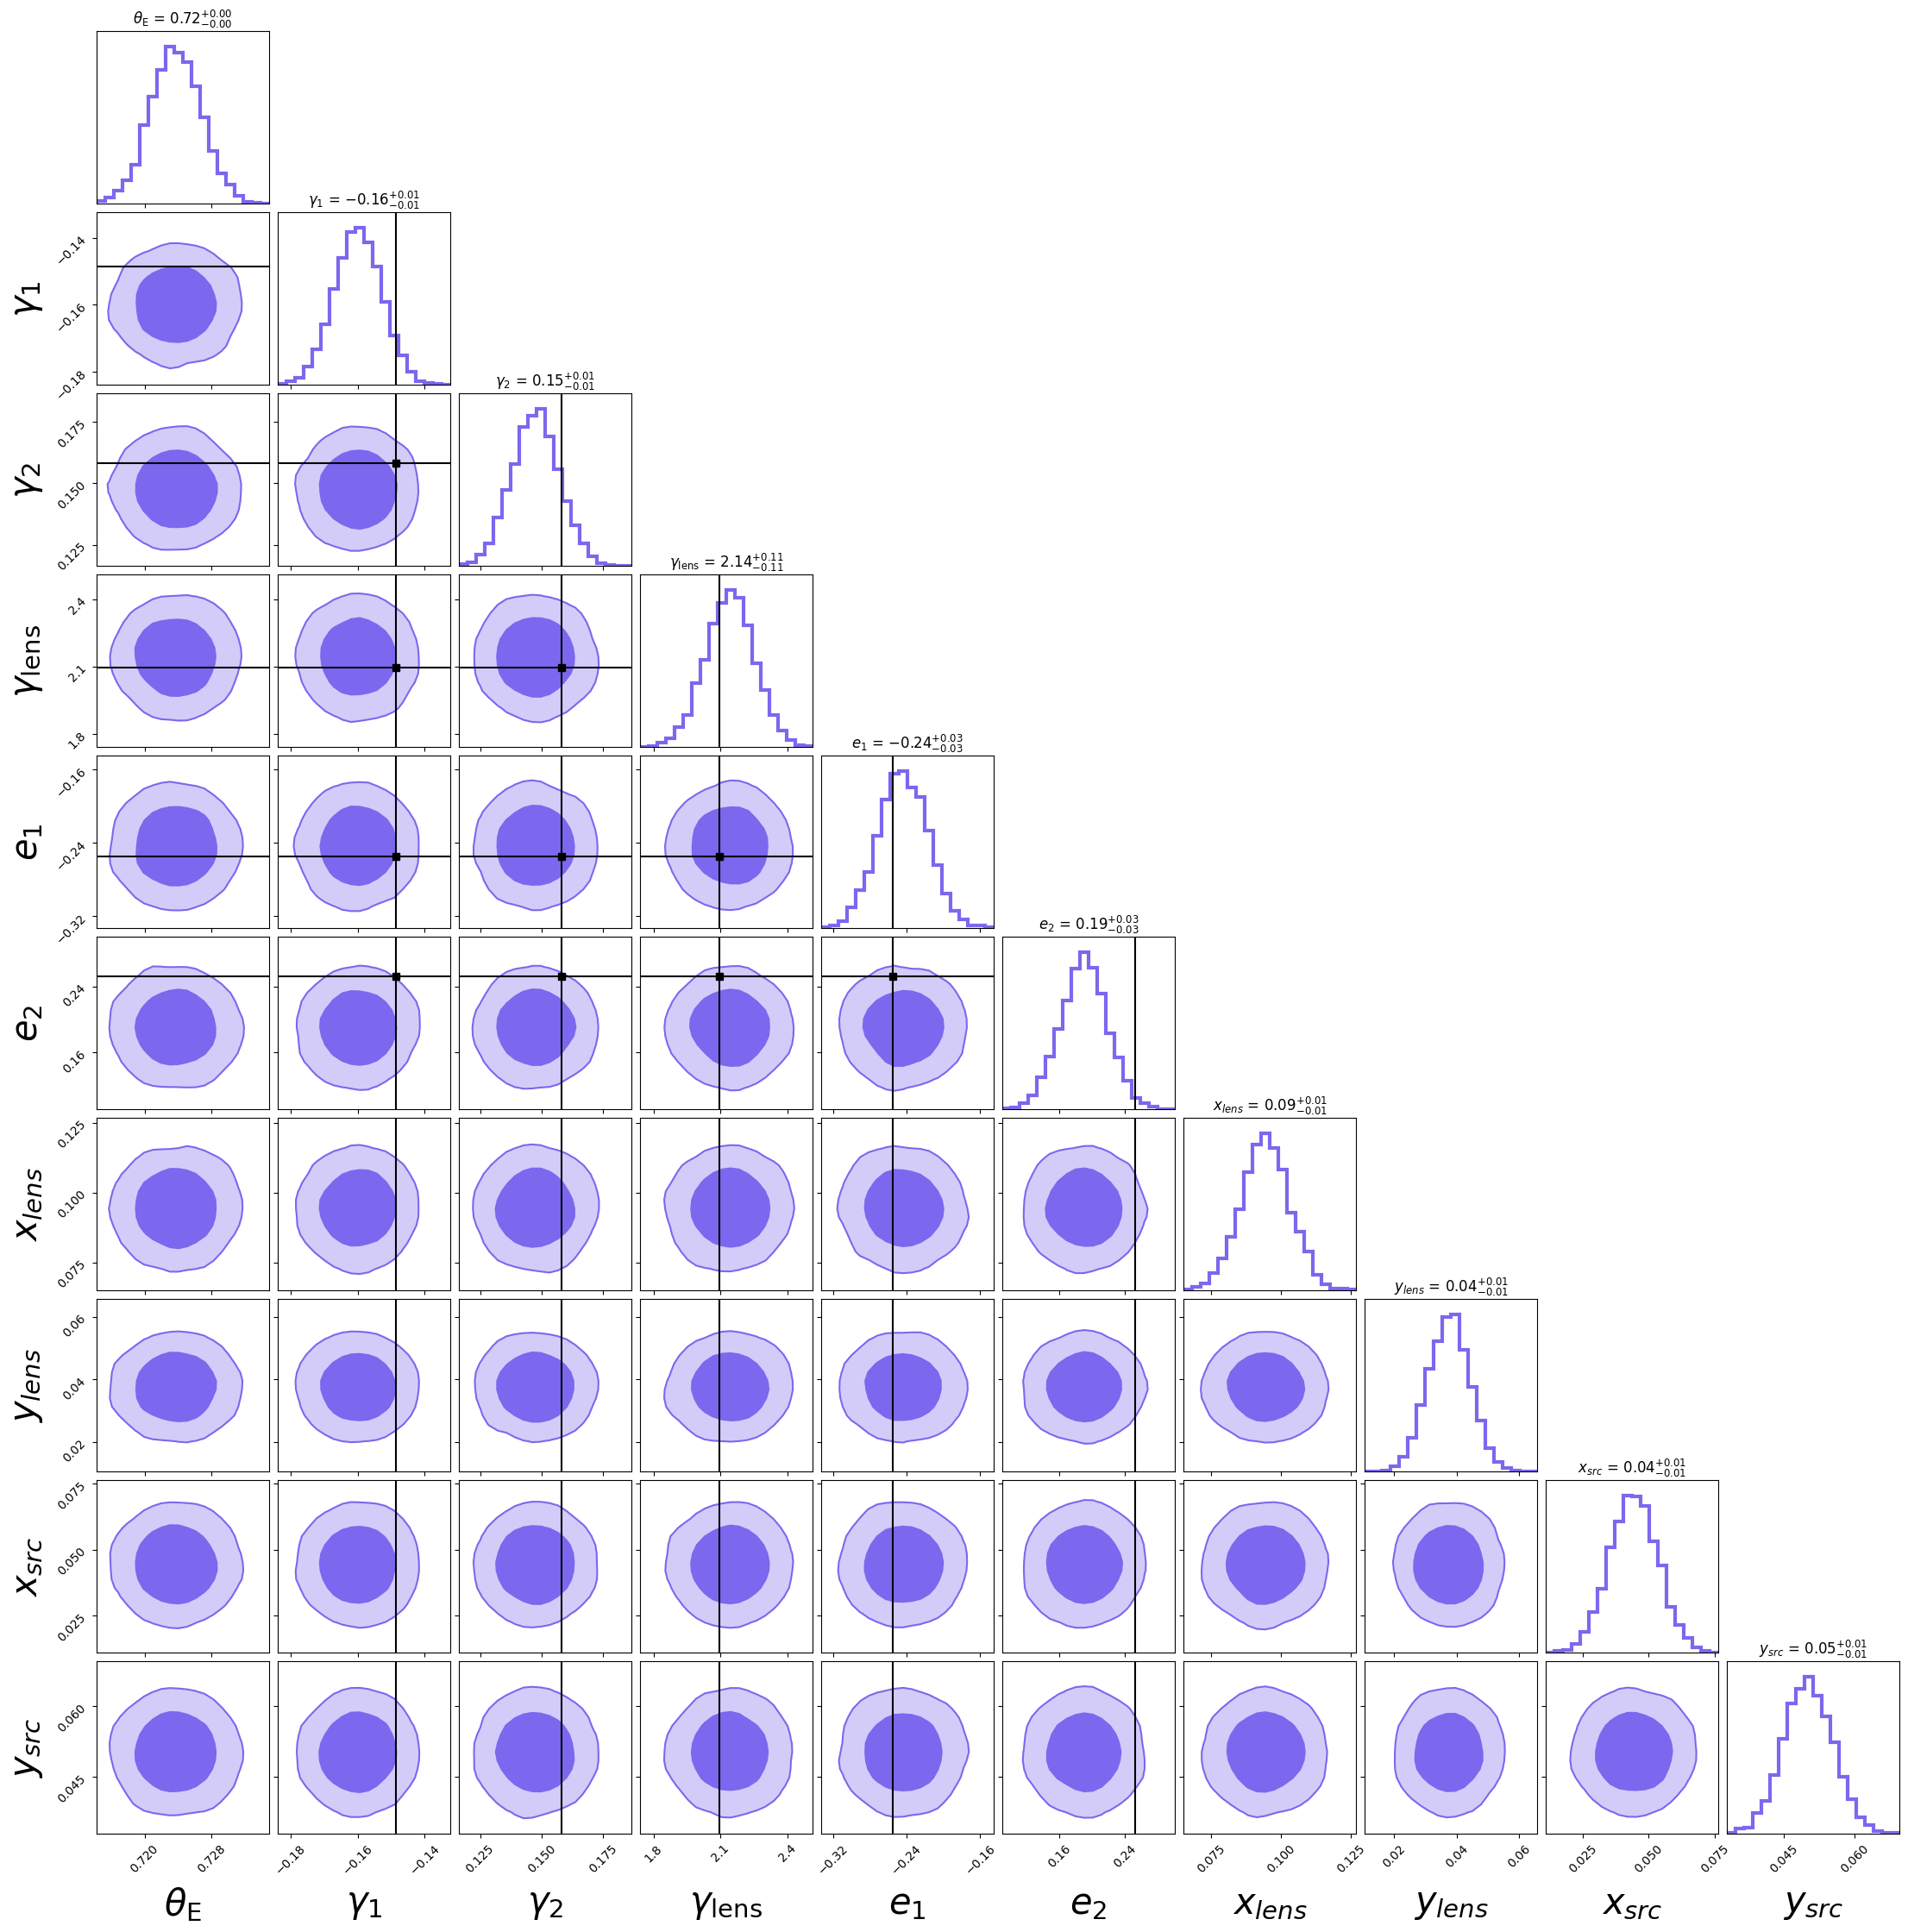

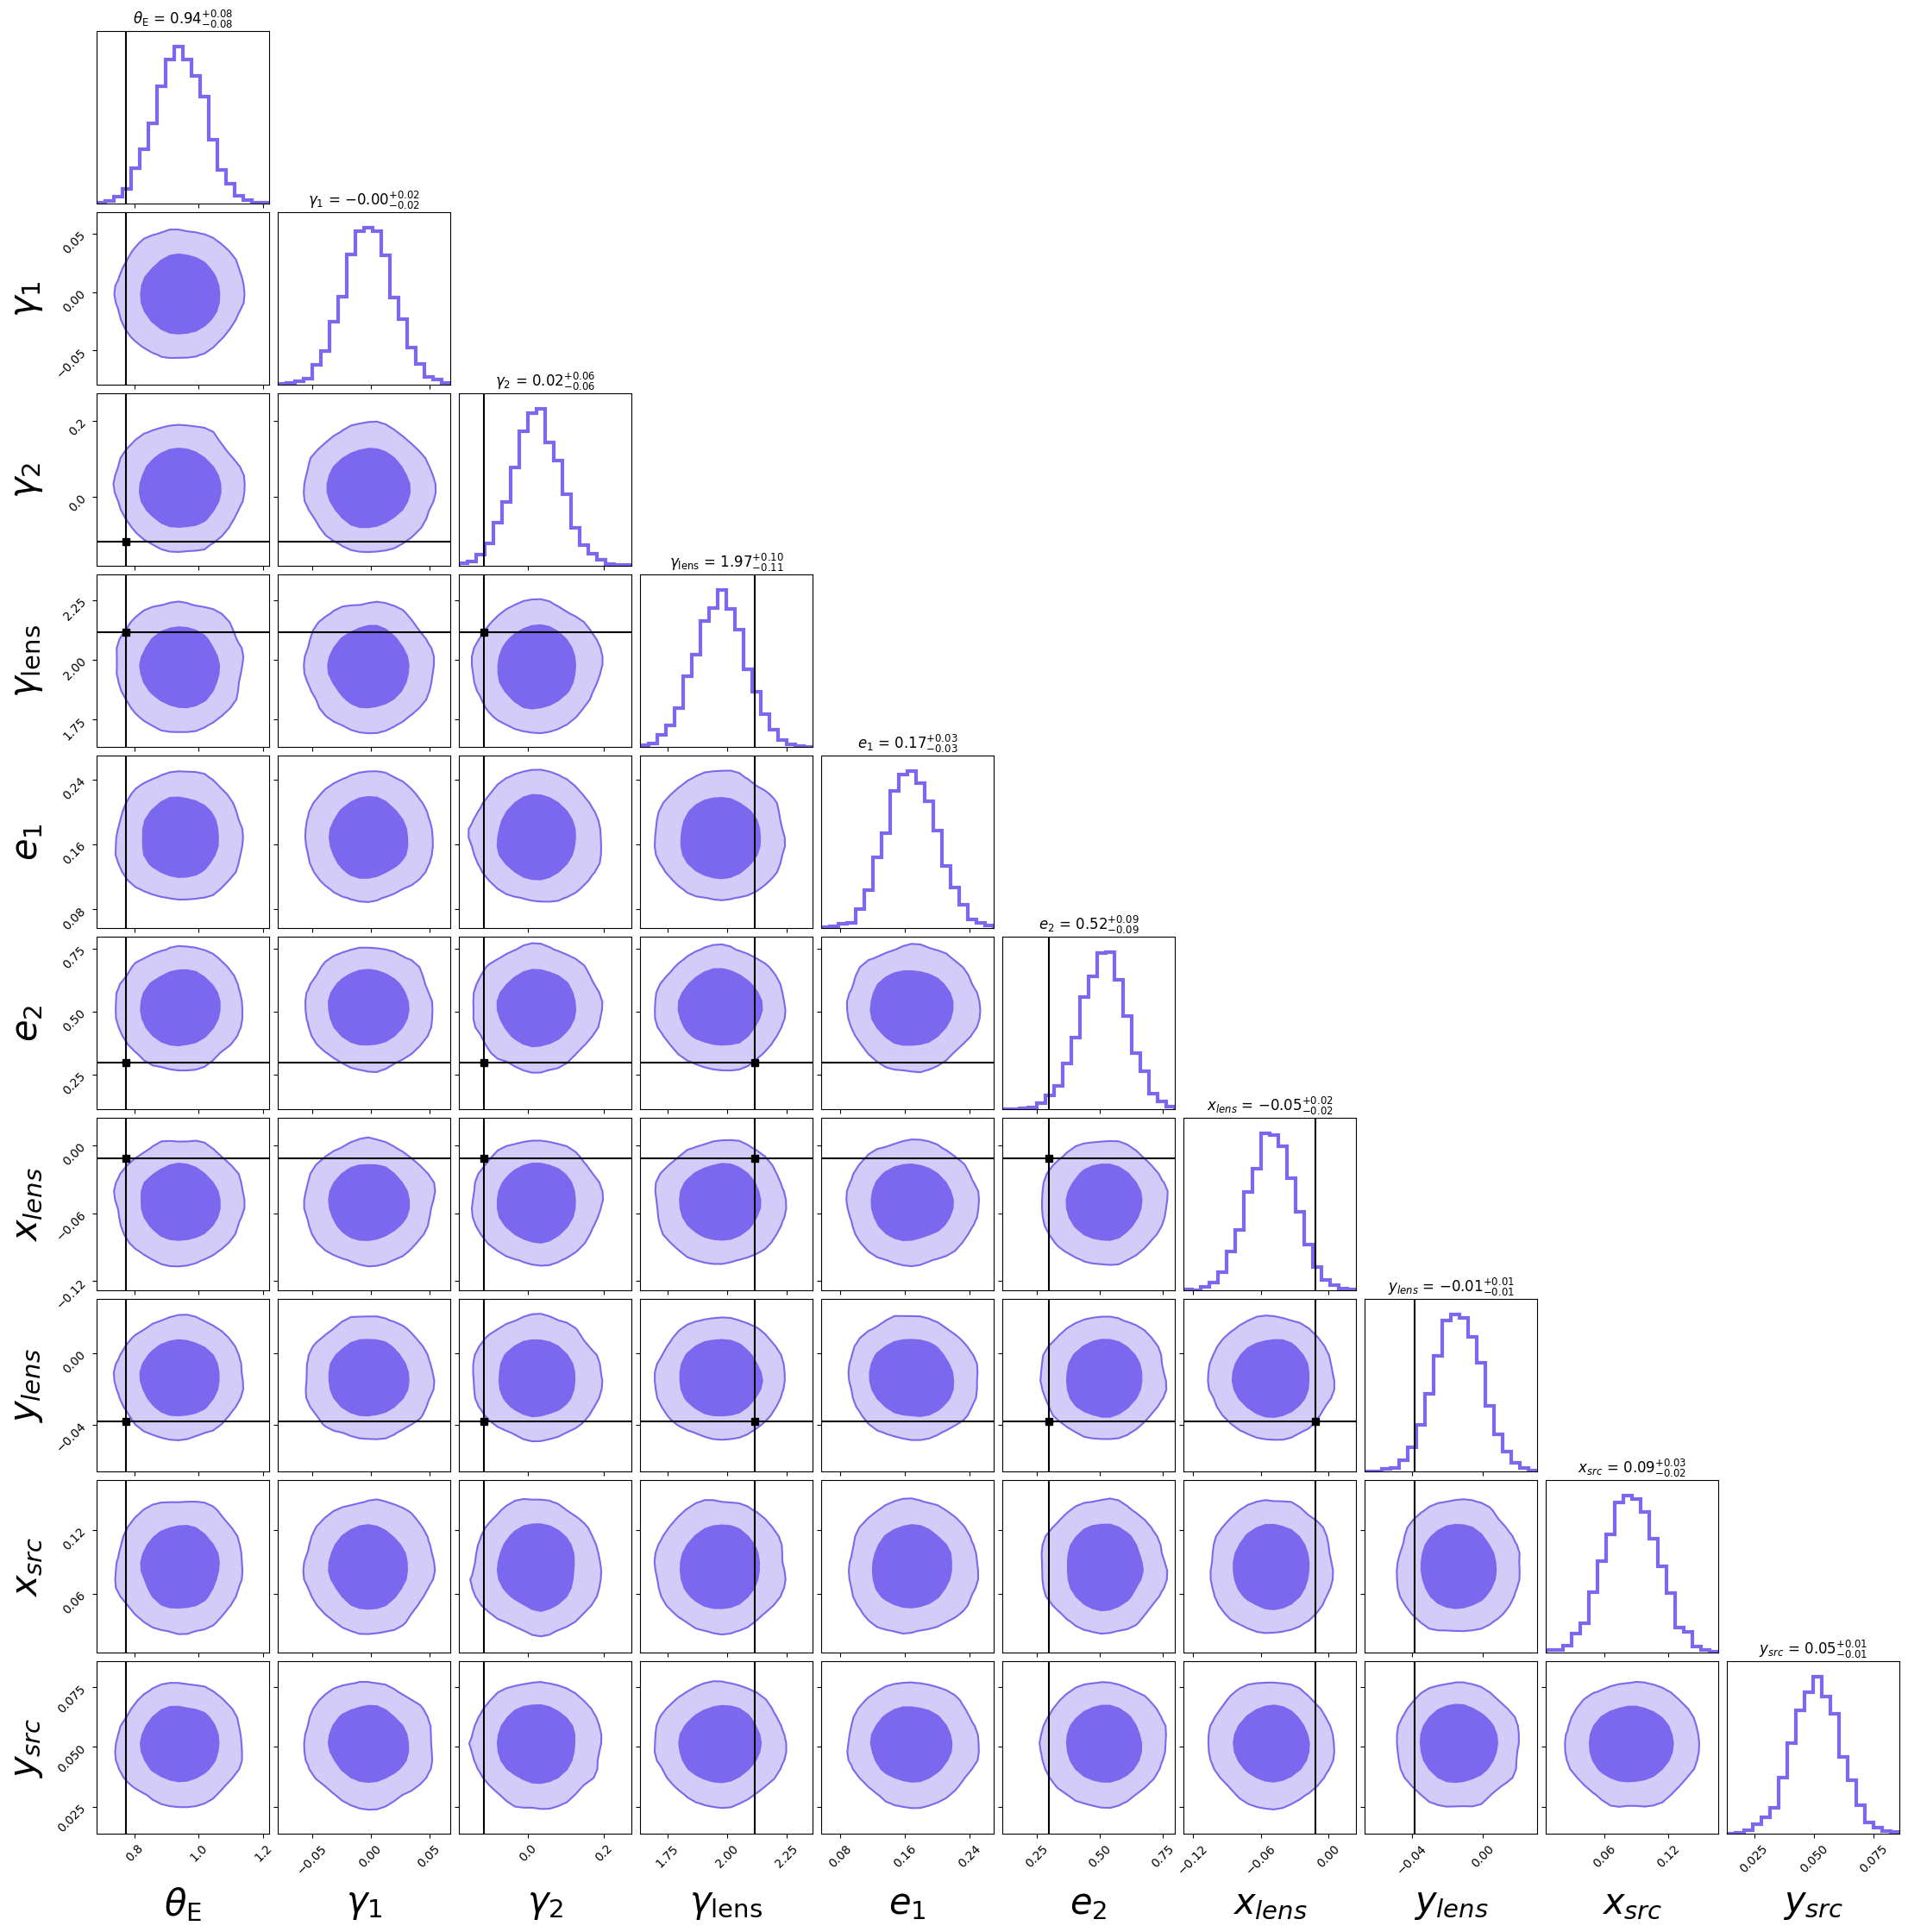

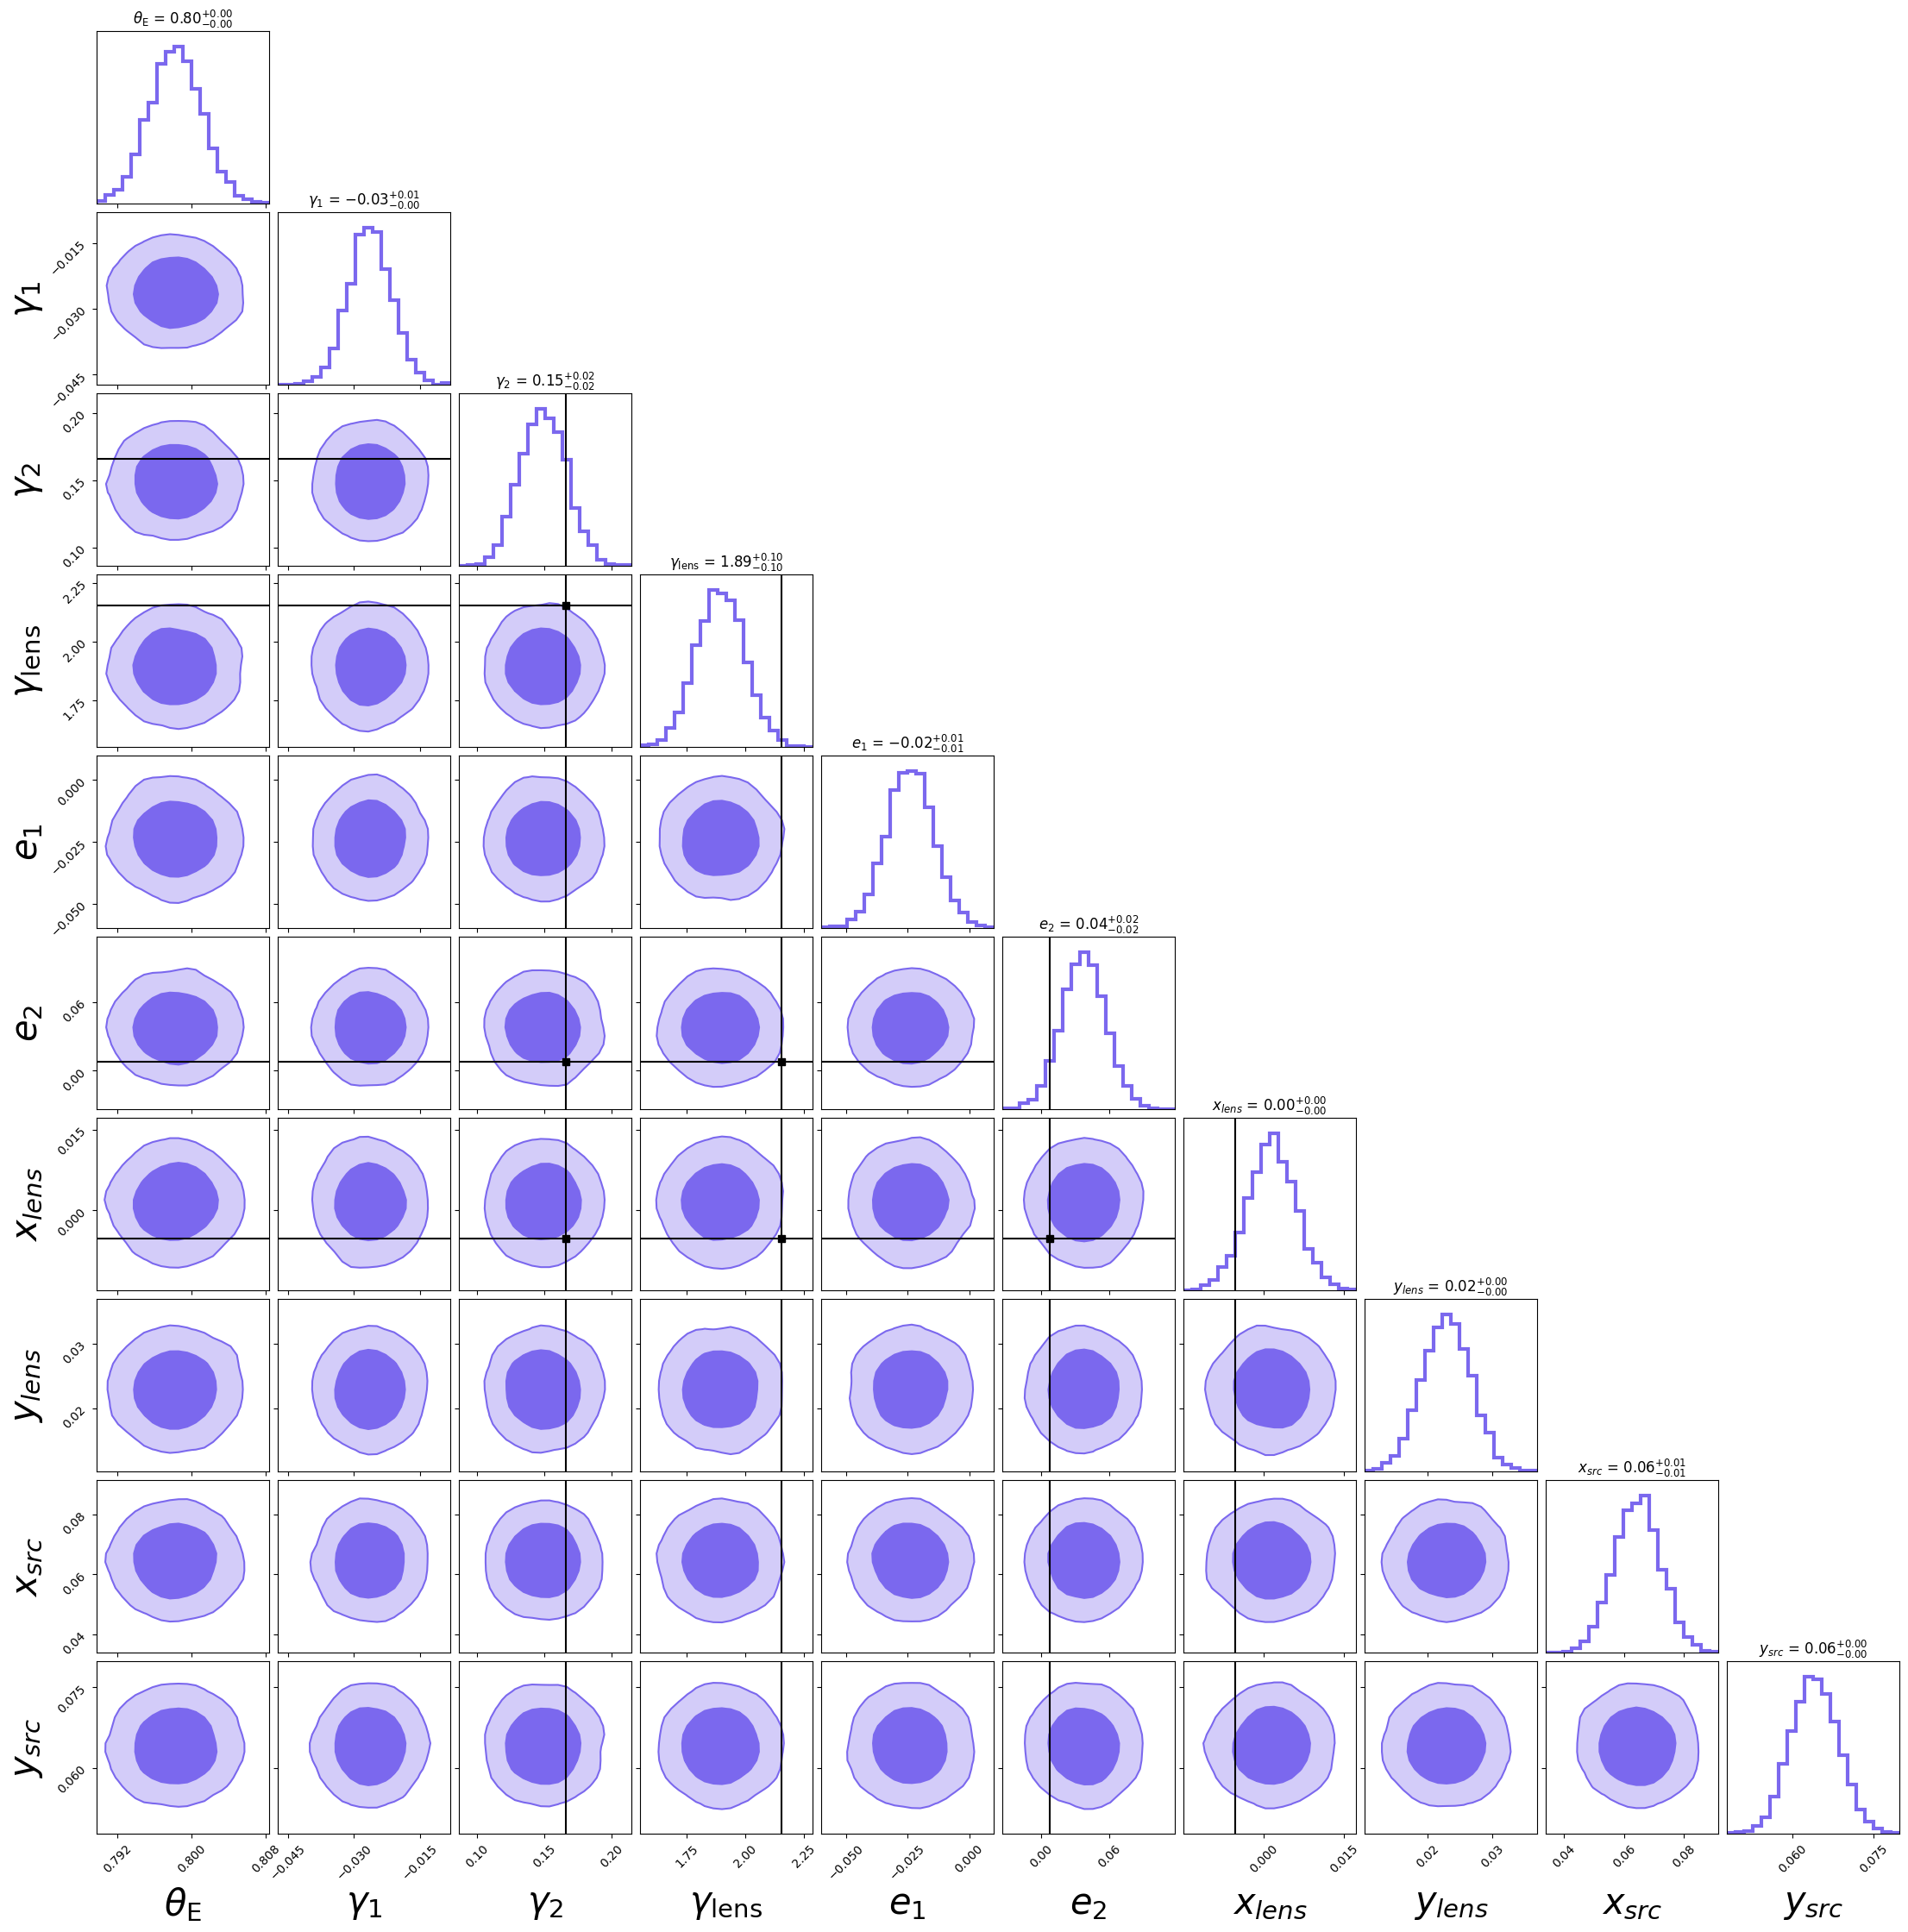

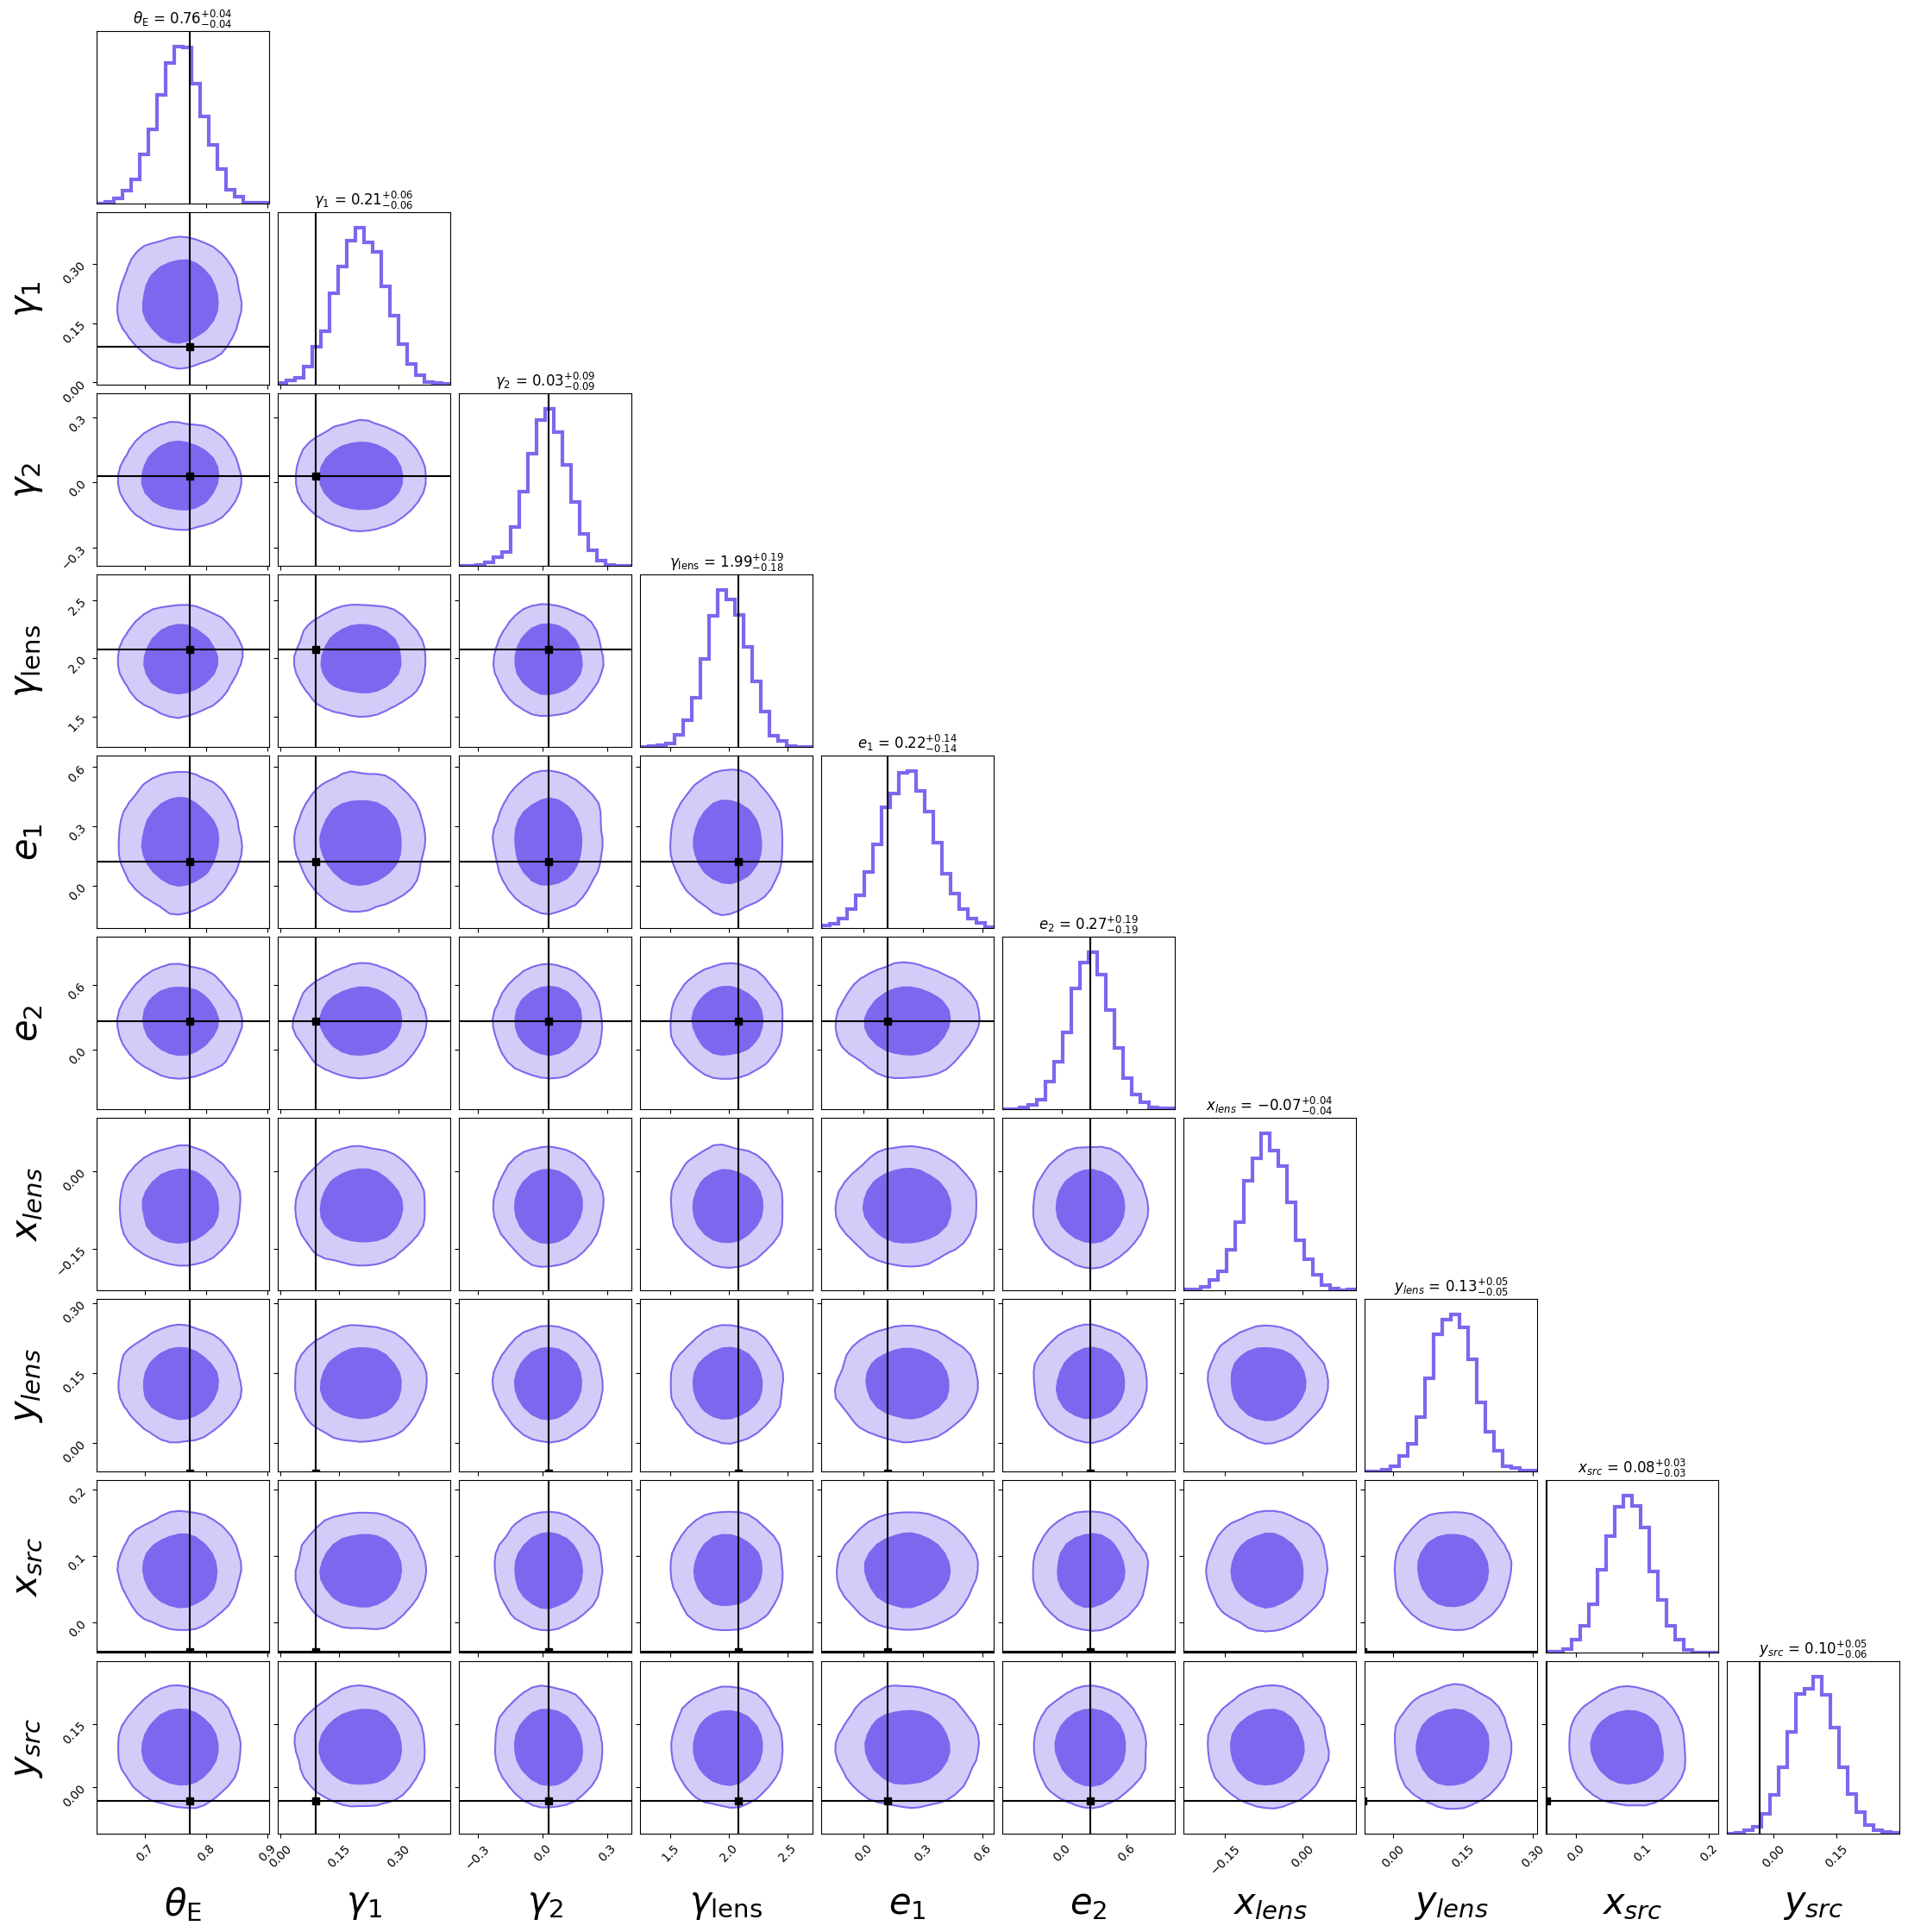

In [7]:
from scipy.stats import multivariate_normal

for i in range(10):
    posterior_samples = multivariate_normal(mean=y_pred[i],cov=np.linalg.inv(prec_pred[i])).rvs(size=int(5e3))

    hist_kwargs = {'density':True,'color':'mediumslateblue','lw':3}

    fig = corner.corner(posterior_samples,labels=np.asarray(learning_params_names),bins=20,
                show_titles=True,plot_datapoints=False,label_kwargs=dict(fontsize=30),
                levels=[0.68,0.95],color='mediumslateblue',fill_contours=True,smooth=1.0,
                hist_kwargs=hist_kwargs,title_fmt='.2f',max_n_ticks=3,fig=None,
                truths=y_test[i],
                truth_color='black')
    #plt.savefig('Images/psJ1606-wpl_cornerplot'+str(i)+'.png')